# Step 3 - Discriminator Trainer

This notebook trains a network to mimic the Blackbox version, using all clients in the training set to perform the task. We use the test set to evaluate how close the Discriminator model is from the Blackbox version.

## Imports

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras.backend as K
from keras.datasets import mnist

print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4-tf


Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params (MUST MATCH Blackbox Evaluator PARAMS)
num_classes = 10
max_epochs = 25
save_every = 1
discriminator_epochs = 25

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


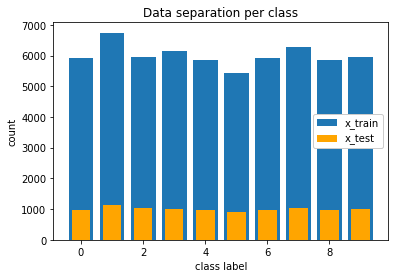

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

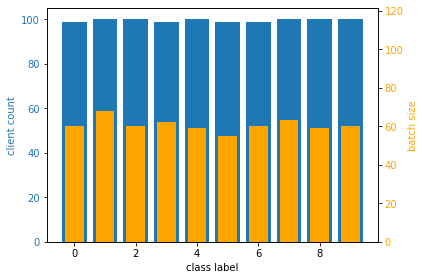

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

#### Load the y_eval sets generated by the Blackbox model

## Build Model

In [10]:
def blackbox_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
    assert depth >= 1
    assert filters >= 1
    assert dense_breadth >= num_classes
    
    h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(input_layer)
    for i in range(depth-1):
        h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(h)
    h = MaxPooling2D(pool_size=(2, 2))(h)
    h = Dropout(0.25)(h, training=training)
    h = Flatten()(h)
    h = Dense(dense_breadth, activation='relu')(h)
    h = Dropout(0.5)(h, training=training)
    output_layer = Dense(num_classes, activation='softmax')(h)
    
    return output_layer

In [11]:
# to remove model complexity, the blackbox and discriminator models will be kept the same

def discriminator_model(input_shape, depth=1, filters=4, dense_breadth=128, training=True):
    model = blackbox_model(input_shape, depth, filters, dense_breadth, training)
    
    return model

In [12]:
input_shape = (target_rows, target_cols, 1)

## Graph Creation

In [ ]:
class DiscriminatorModel:
    
    def __init__(self, input_shape, depth, filters, dense, training=True):
        self.input_shape = input_shape
        self.training = training
        self.depth = depth
        self.filters = filters
        self.dense = dense
        
        self.accumulate_ops = None
        self.train_step = None
        self.zero_ops = None
        
        self.create_graph()
        self.create_optimizer()
        self.split_learning_ops()
        
    def create_graph(self):
        # add place for input and pred label
        self.x = keras.Input(shape=self.input_shape)
        self.y_discriminator = discriminator_model(self.x, self.depth, self.filters, self.dense, training=self.training)
        
        # add node for input from evaluated model
        self.y_blackbox = keras.Input(shape=(num_classes, ))

        # add place for truth label
        self.y_true = keras.Input(shape=(num_classes, ))
        
    def create_optimizer(self):
        # Define loss function in terms of y_pred and y_true
        self.loss = keras.losses.MSE(self.y_blackbox, self.y_discriminator)

        # Setup metrics to look at during training:
        _, self.acc_op_b = tf.metrics.accuracy(labels=tf.argmax(self.y_true, 1), predictions=tf.argmax(self.y_blackbox,1))
        _, self.acc_op_d = tf.metrics.accuracy(labels=tf.argmax(self.y_true, 1), predictions=tf.argmax(self.y_discriminator,1))

        ## Optimizer definition - nothing different from any classical example
        optimizer = tf.train.AdamOptimizer()

        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver(max_to_keep=discriminator_epochs)
        
    def split_learning_ops(self):
        # INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

        # Fetch a list of our network's trainable parameters.
        self.trainable_vars = tf.trainable_variables()

        # Create variables to store accumulated gradients
        self.accumulators = [
            tf.Variable(
                tf.zeros_like(tv.initialized_value()),
                trainable=False
            ) for tv in self.trainable_vars
        ]

        # Create a variable for counting the number of accumulations
        self.accumulation_counter = tf.Variable(0.0, trainable=False)

        # Compute gradients; grad_pairs contains (gradient, variable) pairs
        self.grad_pairs = self.optimizer.compute_gradients(self.loss, self.trainable_vars)

        # Create operations which add a variable's gradient to its accumulator.
        self.accumulate_ops = [
            accumulator.assign_add(
                grad
            ) for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)
        ]

        # The final accumulation operation is to increment the counter
        self.accumulate_ops.append(self.accumulation_counter.assign_add(1.0))

        # Update trainable variables by applying the accumulated gradients
        # divided by the counter. Note: apply_gradients takes in a list of 
        # (grad, var) pairs
        self.train_step = self.optimizer.apply_gradients(
            [(accumulator / self.accumulation_counter, var) \
                for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
        )

        # Accumulators must be zeroed once the accumulated gradient is applied.
        self.zero_ops = [
            accumulator.assign(
                tf.zeros_like(tv)
            ) for (accumulator, tv) in zip(self.accumulators, self.trainable_vars)
        ]

        # Add one last op for zeroing the counter
        self.zero_ops.append(self.accumulation_counter.assign(0.0))
        
    def count_params(self):
        # create a model representation
        model_ = keras.Model(inputs=self.x, outputs=self.y_pred)
        
        # return the number of parameters
        return model_.count_params()

## Split Training

In [ ]:
# List of the different configurations we will step through

configs_depth = list(range(1, 11, 4))
configs_filters = list(range(1, 81, 32))
configs_dense = list(range(10, 200, 100))
total_combinations = len(configs_depth) * len(configs_filters) * len(configs_dense)
total_combinations *= total_combinations

print('{} total combinations of networks'.format(total_combinations))
print('depths:', configs_depth)
print('filters:', configs_filters)
print('denses:', configs_dense)

In [ ]:
print('Training the Discriminator models...\n')

inc = 0
for depth_d in configs_depth:
    for filters_d in configs_filters:
        for dense_d in configs_dense:
            
            for depth_b in configs_depth:
                for filters_b in configs_filters:
                    for dense_b in configs_dense:
                        
                    
            
                        print('{}/{}'.format(inc+1, total_combinations)+'='*40)
                        print('Evaluating blackbox_e{}_d{}_f{}_d{}'.format(max_epochs, depth, filters, dense))
                        filename = "blackbox_e{}_d{}_f{}_d{}".format(max_epochs, depth, filters, dense)

                        # train a new model each time:
                        model_obj = BlackBoxModel(input_shape, depth, filters, dense, training=True)

                        param_count = model_obj.count_params()

                        with tf.Session() as sess:
                            # init the session:
                            sess.run(tf.local_variables_initializer())
                            sess.run(tf.global_variables_initializer())

                            # load the weights for the blackbox:
                            checkpoint_folder = "./blackbox_checkpoints/{}".format(filename)
                            blackbox_weights_path = os.path.join(checkpoint_folder, 'blackbox_checkpoint')
                            # model.load_weights(blackbox_weights_path)
                            model_obj.saver.restore(sess, blackbox_weights_path)

                            # Calculate test acc and loss - to double check loader is working
                            acc_test, loss_test = sess.run([model_obj.acc_op, model_obj.loss], 
                                                           feed_dict={model_obj.x: x_test, model_obj.y_true: y_test})
                            print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
                            print()

                            # evaluate the model for all training data:
                            eval_folder = "./blackbox_evals/{}".format(filename)
                            if os.path.exists(eval_folder):
                                shutil.rmtree(eval_folder)
                            os.makedirs(eval_folder, exist_ok=True)

                            batch_idxs = list(range(len(x_batches)))
                            for batch_idx in tqdm_notebook(batch_idxs):
                                class_idx, x_batch = x_batches[batch_idx]
                                _, y_batch = y_batches[batch_idx]

                                # save output of every batch to a pickle file:
                                y_eval = sess.run(model_obj.y_pred, feed_dict={model_obj.x: x_batch})

                                eval_file = os.path.join(eval_folder, 'train_{}.pkl'.format(batch_idx))
                                with open(eval_file, 'wb') as f:
                                    pickle.dump(y_eval, f)

                            # evaluate and save the model for all testing data:
                            y_eval = sess.run(model_obj.y_pred, feed_dict={model_obj.x: x_test})

                            eval_file = os.path.join(eval_folder, 'test_all.pkl')
                            with open(eval_file, 'wb') as f:
                                pickle.dump(y_eval, f)

                            # dump param number to file:
                            param_file = os.path.join(eval_folder, 'param_count.pkl')
                            with open(param_file, 'wb') as f:
                                pickle.dump(param_count, f)

                        # Flush out the session
                        keras.backend.clear_session()

In [16]:
# Initialize the session

sess = tf.Session()
sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [17]:
# Save the original (init) weights, so that we can jump back to this state after each blackbox_e model
# checkpoint params
null_folder = "./discriminator_checkpoints/null"
if os.path.exists(null_folder):
    shutil.rmtree(null_folder)
os.makedirs(null_folder, exist_ok=True)
null_weights_path = os.path.join(null_folder, 'discriminator_checkpoint.ckpt')

# Save the weights
saver.save(sess, null_weights_path)
#model.save_weights(blackbox_weights_path)
print("Saved the discriminator's initial weights")

Saved the discriminator's initial weights


In [18]:
# Train

print('Training the model...\n')

# Loop through every trained blackbox model, and train a new discriminator on it:
for blackbox_epoch in range(max_epochs):
    if (blackbox_epoch+1) % save_every == 0 or blackbox_epoch+1 == max_epochs:
        
        print('='*40)
        # Load the discriminator's initial weights to reset the graph:
        saver.restore(sess, null_weights_path)
        print('Reset graph to its initial state')
        print()
        
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        
        #######################################################################################
        
        # Load the outputs from the blackbox
        print('='*40)
        print('Loading previous blackbox_e{} evaluation'.format(blackbox_epoch+1))
        print()
        
        # load the pickle files:
        eval_folder = "./blackbox_evals/blackbox_e{}".format(blackbox_epoch+1)
        
        # load training batches
        batch_idxs = list(range(len(x_batches)))
        blackbox_train_batches = []
        for batch_idx in batch_idxs:
            eval_file = os.path.join(eval_folder, 'train_{}.pkl'.format(batch_idx))
            with open(eval_file, 'rb') as f:
                y_eval = pickle.load(f)
            blackbox_train_batches.append(y_eval)
            
        # load testing batches
        eval_file = os.path.join(eval_folder, 'test_all.pkl')
        with open(eval_file, 'rb') as f:
            y_eval = pickle.load(f)
        b_test = y_eval
        
        #######################################################################################
        
        # Train the discriminator
        print('='*40)
        print('Training on blackbox_e{}'.format(blackbox_epoch+1))
        
        acc_train_b_tracker = []
        acc_test_b_tracker = []
        acc_train_d_tracker = []
        acc_test_d_tracker = []
        loss_train_tracker = []
        loss_test_tracker = []
        
        for epoch in range(discriminator_epochs):
            print('.'*10)
            print('Epoch %s:' % str(epoch+1))

            batch_idxs = list(range(len(x_batches)))
            if shuffle_clients:
                # shuffle the batches each time
                random.shuffle(batch_idxs)

            # Run the zero_ops to initialize the accumulators
            sess.run(zero_ops)

            # Fancy progress bar
            samples = x_train.shape[0]
            pbar = tqdm_notebook(total=samples)

            # Keep track of average loss/acc per class:
            accs_train_b = []
            accs_train_d = []
            losses_train = []

            # Iterate over clients:
            grad_feed_dict = dict()
            for i, batch_idx in enumerate(batch_idxs):
                class_idx, x_batch = x_batches[batch_idx]
                _, y_batch = y_batches[batch_idx]
                b_batch = blackbox_train_batches[batch_idx]

                # Iterate over the client's batch in minibatches:
                j = 0
                while(j < len(x_batch)):
                    if minibatch_size is None:
                        # use whole batch (no minibatch)
                        x_minibatch = x_batch
                        y_minibatch = y_batch
                        b_minibatch = b_batch
                    else:
                        x_minibatch = x_batch[j:(j+minibatch_size)]
                        y_minibatch = y_batch[j:(j+minibatch_size)]
                        b_minibatch = b_batch[j:(j+minibatch_size)]

                    # get the gradients and determine accuracy/loss of model on training dataset
                    _, acc_train_b, acc_train_d, loss_train = sess.run([
                        accumulate_ops, acc_op_b, acc_op_d, loss], feed_dict={x: x_minibatch, y_blackbox: b_minibatch,
                                                                              y_true: y_minibatch})

                    # add acc and loss metrics for batch:
                    accs_train_b.append(acc_train_b)
                    accs_train_d.append(acc_train_d)
                    losses_train.append(np.mean(loss_train))

                    if minibatch_size is None:
                        break
                    else:
                        j += minibatch_size

                # increment pbar
                pbar.update(len(x_batch))
                pbar.set_description('train_loss={:e}'.format(np.mean(losses_train)))

                # perform a train step every batches_per_train_step number of batches:
                if (i > 0 and i % batches_per_train_step == 0) or i == len(batch_idxs) - 1:
                    # Run the train_step ops to update the weights based on our accumulated gradients
                    sess.run(train_step)

                    # zero out the accumulators
                    sess.run(zero_ops)

            pbar.update(x_train.shape[0] - pbar.n)
            pbar.close()

            # Calculate test acc and loss
            acc_test_b, acc_test_d, loss_test = sess.run([acc_op_b, acc_op_d, loss], feed_dict={x: x_test, y_blackbox: b_test,
                                                                                                y_true: y_test})

            # Update progress bar
            print('Train Accuracy: D[{:.3f}] --> B[{:.3f}] | MSE(D): {:e}'.format(np.mean(accs_train_d), np.mean(accs_train_b),
                                                                          np.mean(losses_train)))
            print('Test Accuracy:  D[{:.3f}] --> B[{:.3f}] | MSE(D): {:e}'.format(acc_test_d, acc_test_b, np.mean(loss_test)))
            print()
            
            # Put the variables into the tracker arrays
            acc_train_b_tracker.append(np.mean(accs_train_b))
            acc_test_b_tracker.append(acc_test_b)
            acc_train_d_tracker.append(np.mean(accs_train_d))
            acc_test_d_tracker.append(acc_test_d)
            loss_train_tracker.append(np.mean(losses_train))
            loss_test_tracker.append(np.sum(loss_test))
            
        # save the tracked training specs
        hist_folder = "./discriminator_histories/blackbox_e{}__discriminator_e{}".format(blackbox_epoch+1,
                                                                                         discriminator_epochs)
        if os.path.exists(hist_folder):
            shutil.rmtree(hist_folder)
        os.makedirs(hist_folder, exist_ok=True)
        
        acc_b_file = os.path.join(hist_folder, 'acc_b.pkl')
        acc_d_file = os.path.join(hist_folder, 'acc_d.pkl')
        loss_file = os.path.join(hist_folder, 'loss.pkl')
        
        with open(acc_b_file, 'wb') as f:
            pickle.dump([acc_train_b_tracker, acc_test_b_tracker], f)
        with open(acc_d_file, 'wb') as f:
            pickle.dump([acc_train_d_tracker, acc_test_d_tracker], f)
        with open(loss_file, 'wb') as f:
            pickle.dump([loss_train_tracker, loss_test_tracker], f)

        # checkpoint params
        checkpoint_folder = "./discriminator_checkpoints/blackbox_e{}__discriminator_e{}".format(blackbox_epoch+1, 
                                                                                                 discriminator_epochs)
        removed = False
        if os.path.exists(checkpoint_folder):
            removed = True
            shutil.rmtree(checkpoint_folder)
        os.makedirs(checkpoint_folder, exist_ok=True)
        discriminator_weights_path = os.path.join(checkpoint_folder, 'discriminator_checkpoint.ckpt')

        # Save the weights
        saver.save(sess, discriminator_weights_path)
        #model.save_weights(blackbox_weights_path)
        print('{} weights for e{}'.format('Overwrote' if removed else 'Saved', epoch+1))
    else:
        pass

Training the model...

INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e1 evaluation

Training on blackbox_e1
..........
Epoch 1:



Train Accuracy: D[0.516] --> B[0.965] | MSE(D): 3.272374e-02
Test Accuracy:  D[0.732] --> B[0.966] | MSE(D): 9.092643e-03

..........
Epoch 2:



Train Accuracy: D[0.781] --> B[0.966] | MSE(D): 6.008065e-03
Test Accuracy:  D[0.826] --> B[0.966] | MSE(D): 3.610426e-03

..........
Epoch 3:



Train Accuracy: D[0.845] --> B[0.966] | MSE(D): 2.744168e-03
Test Accuracy:  D[0.866] --> B[0.966] | MSE(D): 2.185985e-03

..........
Epoch 4:



Train Accuracy: D[0.876] --> B[0.966] | MSE(D): 2.113632e-03
Test Accuracy:  D[0.888] --> B[0.966] | MSE(D): 1.794807e-03

..........
Epoch 5:



Train Accuracy: D[0.894] --> B[0.966] | MSE(D): 1.709261e-03
Test Accuracy:  D[0.902] --> B[0.966] | MSE(D): 1.456241e-03

..........
Epoch 6:



Train Accuracy: D[0.906] --> B[0.966] | MSE(D): 1.486041e-03
Test Accuracy:  D[0.911] --> B[0.966] | MSE(D): 1.467839e-03

..........
Epoch 7:



Train Accuracy: D[0.914] --> B[0.966] | MSE(D): 1.417360e-03
Test Accuracy:  D[0.918] --> B[0.966] | MSE(D): 1.306345e-03

..........
Epoch 8:



Train Accuracy: D[0.921] --> B[0.966] | MSE(D): 1.352939e-03
Test Accuracy:  D[0.924] --> B[0.966] | MSE(D): 1.270139e-03

..........
Epoch 9:



Train Accuracy: D[0.926] --> B[0.966] | MSE(D): 1.289927e-03
Test Accuracy:  D[0.928] --> B[0.966] | MSE(D): 1.331411e-03

..........
Epoch 10:



Train Accuracy: D[0.929] --> B[0.966] | MSE(D): 1.245697e-03
Test Accuracy:  D[0.931] --> B[0.966] | MSE(D): 1.164926e-03

..........
Epoch 11:



Train Accuracy: D[0.933] --> B[0.966] | MSE(D): 1.187318e-03
Test Accuracy:  D[0.934] --> B[0.966] | MSE(D): 1.307007e-03

..........
Epoch 12:



Train Accuracy: D[0.935] --> B[0.966] | MSE(D): 1.175247e-03
Test Accuracy:  D[0.937] --> B[0.966] | MSE(D): 1.141700e-03

..........
Epoch 13:



Train Accuracy: D[0.937] --> B[0.966] | MSE(D): 1.095601e-03
Test Accuracy:  D[0.939] --> B[0.966] | MSE(D): 1.193431e-03

..........
Epoch 14:



Train Accuracy: D[0.939] --> B[0.966] | MSE(D): 1.072924e-03
Test Accuracy:  D[0.940] --> B[0.966] | MSE(D): 1.043843e-03

..........
Epoch 15:



Train Accuracy: D[0.941] --> B[0.966] | MSE(D): 1.087662e-03
Test Accuracy:  D[0.942] --> B[0.966] | MSE(D): 1.103779e-03

..........
Epoch 16:



Train Accuracy: D[0.942] --> B[0.966] | MSE(D): 1.047606e-03
Test Accuracy:  D[0.943] --> B[0.966] | MSE(D): 1.148841e-03

..........
Epoch 17:



Train Accuracy: D[0.944] --> B[0.966] | MSE(D): 1.028789e-03
Test Accuracy:  D[0.944] --> B[0.966] | MSE(D): 1.110795e-03

..........
Epoch 18:



Train Accuracy: D[0.945] --> B[0.966] | MSE(D): 1.015035e-03
Test Accuracy:  D[0.946] --> B[0.966] | MSE(D): 1.059493e-03

..........
Epoch 19:



Train Accuracy: D[0.946] --> B[0.966] | MSE(D): 9.821842e-04
Test Accuracy:  D[0.947] --> B[0.966] | MSE(D): 1.093228e-03

..........
Epoch 20:



Train Accuracy: D[0.947] --> B[0.966] | MSE(D): 9.674762e-04
Test Accuracy:  D[0.947] --> B[0.966] | MSE(D): 1.137080e-03

..........
Epoch 21:



Train Accuracy: D[0.948] --> B[0.966] | MSE(D): 9.772404e-04
Test Accuracy:  D[0.948] --> B[0.966] | MSE(D): 9.745858e-04

..........
Epoch 22:



Train Accuracy: D[0.948] --> B[0.966] | MSE(D): 9.390744e-04
Test Accuracy:  D[0.949] --> B[0.966] | MSE(D): 1.069778e-03

..........
Epoch 23:



Train Accuracy: D[0.949] --> B[0.966] | MSE(D): 9.293432e-04
Test Accuracy:  D[0.950] --> B[0.966] | MSE(D): 1.047570e-03

..........
Epoch 24:



Train Accuracy: D[0.950] --> B[0.966] | MSE(D): 9.227213e-04
Test Accuracy:  D[0.950] --> B[0.966] | MSE(D): 1.010890e-03

..........
Epoch 25:



Train Accuracy: D[0.950] --> B[0.966] | MSE(D): 9.041360e-04
Test Accuracy:  D[0.951] --> B[0.966] | MSE(D): 9.668863e-04

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e2 evaluation

Training on blackbox_e2
..........
Epoch 1:



Train Accuracy: D[0.494] --> B[0.978] | MSE(D): 3.753532e-02
Test Accuracy:  D[0.715] --> B[0.978] | MSE(D): 1.081615e-02

..........
Epoch 2:



Train Accuracy: D[0.769] --> B[0.978] | MSE(D): 7.574602e-03
Test Accuracy:  D[0.819] --> B[0.978] | MSE(D): 4.393540e-03

..........
Epoch 3:



Train Accuracy: D[0.841] --> B[0.978] | MSE(D): 3.670909e-03
Test Accuracy:  D[0.863] --> B[0.978] | MSE(D): 2.598032e-03

..........
Epoch 4:



Train Accuracy: D[0.874] --> B[0.978] | MSE(D): 2.286550e-03
Test Accuracy:  D[0.887] --> B[0.978] | MSE(D): 1.813281e-03

..........
Epoch 5:



Train Accuracy: D[0.895] --> B[0.978] | MSE(D): 1.761162e-03
Test Accuracy:  D[0.903] --> B[0.978] | MSE(D): 1.558730e-03

..........
Epoch 6:



Train Accuracy: D[0.908] --> B[0.978] | MSE(D): 1.570443e-03
Test Accuracy:  D[0.914] --> B[0.978] | MSE(D): 1.386042e-03

..........
Epoch 7:



Train Accuracy: D[0.918] --> B[0.978] | MSE(D): 1.442801e-03
Test Accuracy:  D[0.922] --> B[0.978] | MSE(D): 1.373143e-03

..........
Epoch 8:



Train Accuracy: D[0.925] --> B[0.978] | MSE(D): 1.292755e-03
Test Accuracy:  D[0.928] --> B[0.978] | MSE(D): 1.375131e-03

..........
Epoch 9:



Train Accuracy: D[0.930] --> B[0.978] | MSE(D): 1.275157e-03
Test Accuracy:  D[0.933] --> B[0.978] | MSE(D): 1.110605e-03

..........
Epoch 10:



Train Accuracy: D[0.935] --> B[0.978] | MSE(D): 1.182849e-03
Test Accuracy:  D[0.937] --> B[0.978] | MSE(D): 1.227277e-03

..........
Epoch 11:



Train Accuracy: D[0.938] --> B[0.978] | MSE(D): 1.128557e-03
Test Accuracy:  D[0.940] --> B[0.978] | MSE(D): 1.254098e-03

..........
Epoch 12:



Train Accuracy: D[0.941] --> B[0.978] | MSE(D): 1.111569e-03
Test Accuracy:  D[0.943] --> B[0.978] | MSE(D): 1.077975e-03

..........
Epoch 13:



Train Accuracy: D[0.944] --> B[0.978] | MSE(D): 1.064203e-03
Test Accuracy:  D[0.945] --> B[0.978] | MSE(D): 1.082372e-03

..........
Epoch 14:



Train Accuracy: D[0.946] --> B[0.978] | MSE(D): 1.017467e-03
Test Accuracy:  D[0.947] --> B[0.978] | MSE(D): 1.010012e-03

..........
Epoch 15:



Train Accuracy: D[0.948] --> B[0.978] | MSE(D): 9.613102e-04
Test Accuracy:  D[0.949] --> B[0.978] | MSE(D): 9.771567e-04

..........
Epoch 16:



Train Accuracy: D[0.950] --> B[0.978] | MSE(D): 9.465066e-04
Test Accuracy:  D[0.951] --> B[0.978] | MSE(D): 1.045013e-03

..........
Epoch 17:



Train Accuracy: D[0.951] --> B[0.978] | MSE(D): 9.336660e-04
Test Accuracy:  D[0.952] --> B[0.978] | MSE(D): 9.518872e-04

..........
Epoch 18:



Train Accuracy: D[0.953] --> B[0.978] | MSE(D): 8.828506e-04
Test Accuracy:  D[0.953] --> B[0.978] | MSE(D): 9.935611e-04

..........
Epoch 19:



Train Accuracy: D[0.954] --> B[0.978] | MSE(D): 8.806101e-04
Test Accuracy:  D[0.954] --> B[0.978] | MSE(D): 9.726201e-04

..........
Epoch 20:



Train Accuracy: D[0.955] --> B[0.978] | MSE(D): 8.956243e-04
Test Accuracy:  D[0.956] --> B[0.978] | MSE(D): 8.730790e-04

..........
Epoch 21:



Train Accuracy: D[0.956] --> B[0.978] | MSE(D): 8.636245e-04
Test Accuracy:  D[0.956] --> B[0.978] | MSE(D): 1.086444e-03

..........
Epoch 22:



Train Accuracy: D[0.957] --> B[0.978] | MSE(D): 8.281265e-04
Test Accuracy:  D[0.957] --> B[0.978] | MSE(D): 1.024978e-03

..........
Epoch 23:



Train Accuracy: D[0.958] --> B[0.978] | MSE(D): 8.800655e-04
Test Accuracy:  D[0.958] --> B[0.978] | MSE(D): 9.744425e-04

..........
Epoch 24:



Train Accuracy: D[0.958] --> B[0.978] | MSE(D): 8.178034e-04
Test Accuracy:  D[0.959] --> B[0.978] | MSE(D): 9.309725e-04

..........
Epoch 25:



Train Accuracy: D[0.959] --> B[0.978] | MSE(D): 8.118211e-04
Test Accuracy:  D[0.960] --> B[0.978] | MSE(D): 9.062253e-04

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e3 evaluation

Training on blackbox_e3
..........
Epoch 1:



Train Accuracy: D[0.547] --> B[0.982] | MSE(D): 3.307974e-02
Test Accuracy:  D[0.760] --> B[0.982] | MSE(D): 9.097367e-03

..........
Epoch 2:



Train Accuracy: D[0.807] --> B[0.982] | MSE(D): 6.126002e-03
Test Accuracy:  D[0.850] --> B[0.982] | MSE(D): 3.477533e-03

..........
Epoch 3:



Train Accuracy: D[0.868] --> B[0.982] | MSE(D): 2.819695e-03
Test Accuracy:  D[0.887] --> B[0.982] | MSE(D): 2.131422e-03

..........
Epoch 4:



Train Accuracy: D[0.897] --> B[0.982] | MSE(D): 1.886655e-03
Test Accuracy:  D[0.908] --> B[0.982] | MSE(D): 1.697133e-03

..........
Epoch 5:



Train Accuracy: D[0.914] --> B[0.982] | MSE(D): 1.570372e-03
Test Accuracy:  D[0.921] --> B[0.982] | MSE(D): 1.460525e-03

..........
Epoch 6:



Train Accuracy: D[0.925] --> B[0.982] | MSE(D): 1.323820e-03
Test Accuracy:  D[0.930] --> B[0.982] | MSE(D): 1.245594e-03

..........
Epoch 7:



Train Accuracy: D[0.933] --> B[0.982] | MSE(D): 1.187946e-03
Test Accuracy:  D[0.936] --> B[0.982] | MSE(D): 1.107480e-03

..........
Epoch 8:



Train Accuracy: D[0.939] --> B[0.982] | MSE(D): 1.086425e-03
Test Accuracy:  D[0.941] --> B[0.982] | MSE(D): 1.175302e-03

..........
Epoch 9:



Train Accuracy: D[0.943] --> B[0.982] | MSE(D): 1.038373e-03
Test Accuracy:  D[0.945] --> B[0.982] | MSE(D): 1.058592e-03

..........
Epoch 10:



Train Accuracy: D[0.947] --> B[0.982] | MSE(D): 9.618778e-04
Test Accuracy:  D[0.949] --> B[0.982] | MSE(D): 1.017000e-03

..........
Epoch 11:



Train Accuracy: D[0.950] --> B[0.982] | MSE(D): 9.682132e-04
Test Accuracy:  D[0.951] --> B[0.982] | MSE(D): 1.053493e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.982] | MSE(D): 9.019193e-04
Test Accuracy:  D[0.954] --> B[0.982] | MSE(D): 9.625508e-04

..........
Epoch 13:



Train Accuracy: D[0.954] --> B[0.982] | MSE(D): 8.770597e-04
Test Accuracy:  D[0.955] --> B[0.982] | MSE(D): 8.957845e-04

..........
Epoch 14:



Train Accuracy: D[0.956] --> B[0.982] | MSE(D): 8.154563e-04
Test Accuracy:  D[0.957] --> B[0.982] | MSE(D): 9.741444e-04

..........
Epoch 15:



Train Accuracy: D[0.958] --> B[0.982] | MSE(D): 8.206249e-04
Test Accuracy:  D[0.959] --> B[0.982] | MSE(D): 1.027070e-03

..........
Epoch 16:



Train Accuracy: D[0.959] --> B[0.982] | MSE(D): 7.593583e-04
Test Accuracy:  D[0.960] --> B[0.982] | MSE(D): 9.090868e-04

..........
Epoch 17:



Train Accuracy: D[0.961] --> B[0.982] | MSE(D): 7.420167e-04
Test Accuracy:  D[0.961] --> B[0.982] | MSE(D): 8.604143e-04

..........
Epoch 18:



Train Accuracy: D[0.962] --> B[0.982] | MSE(D): 7.344853e-04
Test Accuracy:  D[0.962] --> B[0.982] | MSE(D): 8.149857e-04

..........
Epoch 19:



Train Accuracy: D[0.963] --> B[0.982] | MSE(D): 7.149341e-04
Test Accuracy:  D[0.963] --> B[0.982] | MSE(D): 9.822883e-04

..........
Epoch 20:



Train Accuracy: D[0.964] --> B[0.982] | MSE(D): 6.836560e-04
Test Accuracy:  D[0.964] --> B[0.982] | MSE(D): 8.501807e-04

..........
Epoch 21:



Train Accuracy: D[0.964] --> B[0.982] | MSE(D): 7.030110e-04
Test Accuracy:  D[0.965] --> B[0.982] | MSE(D): 9.198510e-04

..........
Epoch 22:



Train Accuracy: D[0.965] --> B[0.982] | MSE(D): 6.758971e-04
Test Accuracy:  D[0.966] --> B[0.982] | MSE(D): 8.031917e-04

..........
Epoch 23:



Train Accuracy: D[0.966] --> B[0.982] | MSE(D): 6.356384e-04
Test Accuracy:  D[0.966] --> B[0.982] | MSE(D): 9.034324e-04

..........
Epoch 24:



Train Accuracy: D[0.967] --> B[0.982] | MSE(D): 6.471025e-04
Test Accuracy:  D[0.967] --> B[0.982] | MSE(D): 8.945115e-04

..........
Epoch 25:



Train Accuracy: D[0.967] --> B[0.982] | MSE(D): 6.666418e-04
Test Accuracy:  D[0.967] --> B[0.982] | MSE(D): 9.512344e-04

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e4 evaluation

Training on blackbox_e4
..........
Epoch 1:



Train Accuracy: D[0.480] --> B[0.985] | MSE(D): 3.740982e-02
Test Accuracy:  D[0.724] --> B[0.984] | MSE(D): 1.158457e-02

..........
Epoch 2:



Train Accuracy: D[0.777] --> B[0.984] | MSE(D): 7.962236e-03
Test Accuracy:  D[0.827] --> B[0.984] | MSE(D): 4.699563e-03

..........
Epoch 3:



Train Accuracy: D[0.848] --> B[0.984] | MSE(D): 4.163499e-03
Test Accuracy:  D[0.870] --> B[0.984] | MSE(D): 3.015809e-03

..........
Epoch 4:



Train Accuracy: D[0.881] --> B[0.984] | MSE(D): 2.952687e-03
Test Accuracy:  D[0.893] --> B[0.984] | MSE(D): 2.337072e-03

..........
Epoch 5:



Train Accuracy: D[0.900] --> B[0.984] | MSE(D): 2.209242e-03
Test Accuracy:  D[0.908] --> B[0.984] | MSE(D): 1.997160e-03

..........
Epoch 6:



Train Accuracy: D[0.913] --> B[0.984] | MSE(D): 1.873777e-03
Test Accuracy:  D[0.919] --> B[0.984] | MSE(D): 1.722067e-03

..........
Epoch 7:



Train Accuracy: D[0.923] --> B[0.984] | MSE(D): 1.662941e-03
Test Accuracy:  D[0.927] --> B[0.984] | MSE(D): 1.581266e-03

..........
Epoch 8:



Train Accuracy: D[0.930] --> B[0.984] | MSE(D): 1.409312e-03
Test Accuracy:  D[0.933] --> B[0.984] | MSE(D): 1.573052e-03

..........
Epoch 9:



Train Accuracy: D[0.935] --> B[0.984] | MSE(D): 1.351098e-03
Test Accuracy:  D[0.938] --> B[0.984] | MSE(D): 1.433889e-03

..........
Epoch 10:



Train Accuracy: D[0.940] --> B[0.984] | MSE(D): 1.236946e-03
Test Accuracy:  D[0.942] --> B[0.984] | MSE(D): 1.398536e-03

..........
Epoch 11:



Train Accuracy: D[0.943] --> B[0.984] | MSE(D): 1.278030e-03
Test Accuracy:  D[0.945] --> B[0.984] | MSE(D): 1.472631e-03

..........
Epoch 12:



Train Accuracy: D[0.946] --> B[0.984] | MSE(D): 1.136806e-03
Test Accuracy:  D[0.948] --> B[0.984] | MSE(D): 1.103526e-03

..........
Epoch 13:



Train Accuracy: D[0.949] --> B[0.984] | MSE(D): 1.082440e-03
Test Accuracy:  D[0.950] --> B[0.984] | MSE(D): 1.177671e-03

..........
Epoch 14:



Train Accuracy: D[0.951] --> B[0.984] | MSE(D): 9.756788e-04
Test Accuracy:  D[0.952] --> B[0.984] | MSE(D): 1.264810e-03

..........
Epoch 15:



Train Accuracy: D[0.953] --> B[0.984] | MSE(D): 9.638059e-04
Test Accuracy:  D[0.954] --> B[0.984] | MSE(D): 1.297672e-03

..........
Epoch 16:



Train Accuracy: D[0.955] --> B[0.984] | MSE(D): 1.011226e-03
Test Accuracy:  D[0.956] --> B[0.984] | MSE(D): 1.120471e-03

..........
Epoch 17:



Train Accuracy: D[0.956] --> B[0.984] | MSE(D): 9.484086e-04
Test Accuracy:  D[0.957] --> B[0.984] | MSE(D): 1.202453e-03

..........
Epoch 18:



Train Accuracy: D[0.958] --> B[0.984] | MSE(D): 9.128373e-04
Test Accuracy:  D[0.958] --> B[0.984] | MSE(D): 1.059320e-03

..........
Epoch 19:



Train Accuracy: D[0.959] --> B[0.984] | MSE(D): 8.663840e-04
Test Accuracy:  D[0.960] --> B[0.984] | MSE(D): 1.273524e-03

..........
Epoch 20:



Train Accuracy: D[0.960] --> B[0.984] | MSE(D): 9.082940e-04
Test Accuracy:  D[0.961] --> B[0.984] | MSE(D): 1.166301e-03

..........
Epoch 21:



Train Accuracy: D[0.961] --> B[0.984] | MSE(D): 8.797647e-04
Test Accuracy:  D[0.962] --> B[0.984] | MSE(D): 1.093494e-03

..........
Epoch 22:



Train Accuracy: D[0.962] --> B[0.984] | MSE(D): 8.472328e-04
Test Accuracy:  D[0.963] --> B[0.984] | MSE(D): 1.025796e-03

..........
Epoch 23:



Train Accuracy: D[0.963] --> B[0.984] | MSE(D): 8.440501e-04
Test Accuracy:  D[0.963] --> B[0.984] | MSE(D): 1.033985e-03

..........
Epoch 24:



Train Accuracy: D[0.964] --> B[0.984] | MSE(D): 8.066229e-04
Test Accuracy:  D[0.964] --> B[0.984] | MSE(D): 1.127455e-03

..........
Epoch 25:



Train Accuracy: D[0.964] --> B[0.984] | MSE(D): 8.295791e-04
Test Accuracy:  D[0.965] --> B[0.984] | MSE(D): 1.007464e-03

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e5 evaluation

Training on blackbox_e5
..........
Epoch 1:



Train Accuracy: D[0.529] --> B[0.987] | MSE(D): 3.376206e-02
Test Accuracy:  D[0.756] --> B[0.988] | MSE(D): 1.122817e-02

..........
Epoch 2:



Train Accuracy: D[0.802] --> B[0.988] | MSE(D): 7.762481e-03
Test Accuracy:  D[0.845] --> B[0.988] | MSE(D): 4.262411e-03

..........
Epoch 3:



Train Accuracy: D[0.864] --> B[0.988] | MSE(D): 3.851027e-03
Test Accuracy:  D[0.883] --> B[0.988] | MSE(D): 2.701559e-03

..........
Epoch 4:



Train Accuracy: D[0.894] --> B[0.988] | MSE(D): 2.570451e-03
Test Accuracy:  D[0.905] --> B[0.988] | MSE(D): 2.402641e-03

..........
Epoch 5:



Train Accuracy: D[0.911] --> B[0.988] | MSE(D): 2.099910e-03
Test Accuracy:  D[0.918] --> B[0.988] | MSE(D): 1.757289e-03

..........
Epoch 6:



Train Accuracy: D[0.922] --> B[0.988] | MSE(D): 1.768342e-03
Test Accuracy:  D[0.927] --> B[0.988] | MSE(D): 1.655081e-03

..........
Epoch 7:



Train Accuracy: D[0.931] --> B[0.988] | MSE(D): 1.543540e-03
Test Accuracy:  D[0.934] --> B[0.988] | MSE(D): 1.470569e-03

..........
Epoch 8:



Train Accuracy: D[0.937] --> B[0.988] | MSE(D): 1.353296e-03
Test Accuracy:  D[0.940] --> B[0.988] | MSE(D): 1.341857e-03

..........
Epoch 9:



Train Accuracy: D[0.942] --> B[0.988] | MSE(D): 1.275983e-03
Test Accuracy:  D[0.944] --> B[0.988] | MSE(D): 1.418958e-03

..........
Epoch 10:



Train Accuracy: D[0.946] --> B[0.988] | MSE(D): 1.142082e-03
Test Accuracy:  D[0.948] --> B[0.988] | MSE(D): 1.263665e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.988] | MSE(D): 1.107515e-03
Test Accuracy:  D[0.951] --> B[0.988] | MSE(D): 1.270283e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.988] | MSE(D): 1.092924e-03
Test Accuracy:  D[0.953] --> B[0.988] | MSE(D): 1.168519e-03

..........
Epoch 13:



Train Accuracy: D[0.954] --> B[0.988] | MSE(D): 9.673860e-04
Test Accuracy:  D[0.955] --> B[0.988] | MSE(D): 1.124670e-03

..........
Epoch 14:



Train Accuracy: D[0.956] --> B[0.988] | MSE(D): 9.311170e-04
Test Accuracy:  D[0.957] --> B[0.988] | MSE(D): 1.070969e-03

..........
Epoch 15:



Train Accuracy: D[0.958] --> B[0.988] | MSE(D): 9.063198e-04
Test Accuracy:  D[0.959] --> B[0.988] | MSE(D): 1.165045e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.988] | MSE(D): 8.773835e-04
Test Accuracy:  D[0.960] --> B[0.988] | MSE(D): 1.146943e-03

..........
Epoch 17:



Train Accuracy: D[0.961] --> B[0.988] | MSE(D): 8.235290e-04
Test Accuracy:  D[0.962] --> B[0.988] | MSE(D): 1.074780e-03

..........
Epoch 18:



Train Accuracy: D[0.962] --> B[0.988] | MSE(D): 8.196589e-04
Test Accuracy:  D[0.963] --> B[0.988] | MSE(D): 1.132340e-03

..........
Epoch 19:



Train Accuracy: D[0.963] --> B[0.988] | MSE(D): 8.313841e-04
Test Accuracy:  D[0.964] --> B[0.988] | MSE(D): 9.081202e-04

..........
Epoch 20:



Train Accuracy: D[0.965] --> B[0.988] | MSE(D): 7.749222e-04
Test Accuracy:  D[0.965] --> B[0.988] | MSE(D): 1.124267e-03

..........
Epoch 21:



Train Accuracy: D[0.965] --> B[0.988] | MSE(D): 7.545850e-04
Test Accuracy:  D[0.966] --> B[0.988] | MSE(D): 1.062349e-03

..........
Epoch 22:



Train Accuracy: D[0.966] --> B[0.988] | MSE(D): 7.520489e-04
Test Accuracy:  D[0.967] --> B[0.988] | MSE(D): 9.961973e-04

..........
Epoch 23:



Train Accuracy: D[0.967] --> B[0.988] | MSE(D): 7.699467e-04
Test Accuracy:  D[0.967] --> B[0.988] | MSE(D): 9.986619e-04

..........
Epoch 24:



Train Accuracy: D[0.968] --> B[0.988] | MSE(D): 7.119987e-04
Test Accuracy:  D[0.968] --> B[0.988] | MSE(D): 1.058193e-03

..........
Epoch 25:



Train Accuracy: D[0.968] --> B[0.988] | MSE(D): 7.255157e-04
Test Accuracy:  D[0.969] --> B[0.988] | MSE(D): 1.032224e-03

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e6 evaluation

Training on blackbox_e6
..........
Epoch 1:



Train Accuracy: D[0.510] --> B[0.990] | MSE(D): 3.962496e-02
Test Accuracy:  D[0.725] --> B[0.990] | MSE(D): 1.508155e-02

..........
Epoch 2:



Train Accuracy: D[0.775] --> B[0.990] | MSE(D): 1.021866e-02
Test Accuracy:  D[0.823] --> B[0.990] | MSE(D): 6.098860e-03

..........
Epoch 3:



Train Accuracy: D[0.844] --> B[0.990] | MSE(D): 5.175494e-03
Test Accuracy:  D[0.867] --> B[0.990] | MSE(D): 3.701666e-03

..........
Epoch 4:



Train Accuracy: D[0.878] --> B[0.990] | MSE(D): 3.480420e-03
Test Accuracy:  D[0.891] --> B[0.990] | MSE(D): 2.638121e-03

..........
Epoch 5:



Train Accuracy: D[0.898] --> B[0.990] | MSE(D): 2.573420e-03
Test Accuracy:  D[0.907] --> B[0.990] | MSE(D): 2.150068e-03

..........
Epoch 6:



Train Accuracy: D[0.912] --> B[0.990] | MSE(D): 2.189899e-03
Test Accuracy:  D[0.918] --> B[0.990] | MSE(D): 1.820648e-03

..........
Epoch 7:



Train Accuracy: D[0.922] --> B[0.990] | MSE(D): 1.902228e-03
Test Accuracy:  D[0.926] --> B[0.990] | MSE(D): 1.694474e-03

..........
Epoch 8:



Train Accuracy: D[0.929] --> B[0.990] | MSE(D): 1.620039e-03
Test Accuracy:  D[0.933] --> B[0.990] | MSE(D): 1.400934e-03

..........
Epoch 9:



Train Accuracy: D[0.935] --> B[0.990] | MSE(D): 1.418980e-03
Test Accuracy:  D[0.938] --> B[0.990] | MSE(D): 1.511427e-03

..........
Epoch 10:



Train Accuracy: D[0.940] --> B[0.990] | MSE(D): 1.372001e-03
Test Accuracy:  D[0.942] --> B[0.990] | MSE(D): 1.521780e-03

..........
Epoch 11:



Train Accuracy: D[0.944] --> B[0.990] | MSE(D): 1.254067e-03
Test Accuracy:  D[0.946] --> B[0.990] | MSE(D): 1.393299e-03

..........
Epoch 12:



Train Accuracy: D[0.947] --> B[0.990] | MSE(D): 1.187639e-03
Test Accuracy:  D[0.949] --> B[0.990] | MSE(D): 1.177168e-03

..........
Epoch 13:



Train Accuracy: D[0.950] --> B[0.990] | MSE(D): 1.139910e-03
Test Accuracy:  D[0.951] --> B[0.990] | MSE(D): 1.301350e-03

..........
Epoch 14:



Train Accuracy: D[0.952] --> B[0.990] | MSE(D): 1.064948e-03
Test Accuracy:  D[0.953] --> B[0.990] | MSE(D): 1.250052e-03

..........
Epoch 15:



Train Accuracy: D[0.954] --> B[0.990] | MSE(D): 9.865257e-04
Test Accuracy:  D[0.955] --> B[0.990] | MSE(D): 1.133335e-03

..........
Epoch 16:



Train Accuracy: D[0.956] --> B[0.990] | MSE(D): 9.573342e-04
Test Accuracy:  D[0.957] --> B[0.990] | MSE(D): 1.212038e-03

..........
Epoch 17:



Train Accuracy: D[0.958] --> B[0.990] | MSE(D): 9.035349e-04
Test Accuracy:  D[0.959] --> B[0.990] | MSE(D): 1.279595e-03

..........
Epoch 18:



Train Accuracy: D[0.959] --> B[0.990] | MSE(D): 8.885005e-04
Test Accuracy:  D[0.960] --> B[0.990] | MSE(D): 1.227931e-03

..........
Epoch 19:



Train Accuracy: D[0.961] --> B[0.990] | MSE(D): 8.401994e-04
Test Accuracy:  D[0.961] --> B[0.990] | MSE(D): 1.131024e-03

..........
Epoch 20:



Train Accuracy: D[0.962] --> B[0.990] | MSE(D): 8.137400e-04
Test Accuracy:  D[0.963] --> B[0.990] | MSE(D): 1.165868e-03

..........
Epoch 21:



Train Accuracy: D[0.963] --> B[0.990] | MSE(D): 8.219234e-04
Test Accuracy:  D[0.964] --> B[0.990] | MSE(D): 1.003385e-03

..........
Epoch 22:



Train Accuracy: D[0.964] --> B[0.990] | MSE(D): 7.784270e-04
Test Accuracy:  D[0.965] --> B[0.990] | MSE(D): 1.004280e-03

..........
Epoch 23:



Train Accuracy: D[0.965] --> B[0.990] | MSE(D): 7.756682e-04
Test Accuracy:  D[0.965] --> B[0.990] | MSE(D): 1.031929e-03

..........
Epoch 24:



Train Accuracy: D[0.966] --> B[0.990] | MSE(D): 7.641651e-04
Test Accuracy:  D[0.966] --> B[0.990] | MSE(D): 1.088055e-03

..........
Epoch 25:



Train Accuracy: D[0.967] --> B[0.990] | MSE(D): 7.505315e-04
Test Accuracy:  D[0.967] --> B[0.990] | MSE(D): 1.041796e-03

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e7 evaluation

Training on blackbox_e7
..........
Epoch 1:



Train Accuracy: D[0.525] --> B[0.991] | MSE(D): 3.627092e-02
Test Accuracy:  D[0.750] --> B[0.990] | MSE(D): 1.083259e-02

..........
Epoch 2:



Train Accuracy: D[0.800] --> B[0.991] | MSE(D): 8.261000e-03
Test Accuracy:  D[0.843] --> B[0.990] | MSE(D): 5.953654e-03

..........
Epoch 3:



Train Accuracy: D[0.862] --> B[0.991] | MSE(D): 4.715377e-03
Test Accuracy:  D[0.882] --> B[0.990] | MSE(D): 3.282783e-03

..........
Epoch 4:



Train Accuracy: D[0.892] --> B[0.990] | MSE(D): 3.264634e-03
Test Accuracy:  D[0.903] --> B[0.990] | MSE(D): 2.504946e-03

..........
Epoch 5:



Train Accuracy: D[0.910] --> B[0.991] | MSE(D): 2.480539e-03
Test Accuracy:  D[0.917] --> B[0.990] | MSE(D): 2.131006e-03

..........
Epoch 6:



Train Accuracy: D[0.921] --> B[0.990] | MSE(D): 2.197435e-03
Test Accuracy:  D[0.927] --> B[0.990] | MSE(D): 2.009444e-03

..........
Epoch 7:



Train Accuracy: D[0.930] --> B[0.990] | MSE(D): 1.794969e-03
Test Accuracy:  D[0.934] --> B[0.990] | MSE(D): 1.619612e-03

..........
Epoch 8:



Train Accuracy: D[0.936] --> B[0.990] | MSE(D): 1.592283e-03
Test Accuracy:  D[0.939] --> B[0.990] | MSE(D): 1.646381e-03

..........
Epoch 9:



Train Accuracy: D[0.941] --> B[0.990] | MSE(D): 1.422888e-03
Test Accuracy:  D[0.944] --> B[0.990] | MSE(D): 1.408118e-03

..........
Epoch 10:



Train Accuracy: D[0.946] --> B[0.990] | MSE(D): 1.346183e-03
Test Accuracy:  D[0.948] --> B[0.990] | MSE(D): 1.386663e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.990] | MSE(D): 1.198093e-03
Test Accuracy:  D[0.951] --> B[0.990] | MSE(D): 1.427825e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.990] | MSE(D): 1.107328e-03
Test Accuracy:  D[0.954] --> B[0.990] | MSE(D): 1.314247e-03

..........
Epoch 13:



Train Accuracy: D[0.955] --> B[0.990] | MSE(D): 9.966856e-04
Test Accuracy:  D[0.956] --> B[0.990] | MSE(D): 1.341634e-03

..........
Epoch 14:



Train Accuracy: D[0.957] --> B[0.990] | MSE(D): 1.013105e-03
Test Accuracy:  D[0.958] --> B[0.990] | MSE(D): 1.128598e-03

..........
Epoch 15:



Train Accuracy: D[0.959] --> B[0.990] | MSE(D): 1.027716e-03
Test Accuracy:  D[0.960] --> B[0.990] | MSE(D): 1.119269e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.990] | MSE(D): 9.481463e-04
Test Accuracy:  D[0.961] --> B[0.990] | MSE(D): 1.203045e-03

..........
Epoch 17:



Train Accuracy: D[0.962] --> B[0.990] | MSE(D): 9.241196e-04
Test Accuracy:  D[0.963] --> B[0.990] | MSE(D): 1.182765e-03

..........
Epoch 18:



Train Accuracy: D[0.963] --> B[0.990] | MSE(D): 8.099981e-04
Test Accuracy:  D[0.964] --> B[0.990] | MSE(D): 9.770698e-04

..........
Epoch 19:



Train Accuracy: D[0.964] --> B[0.990] | MSE(D): 7.456908e-04
Test Accuracy:  D[0.965] --> B[0.990] | MSE(D): 1.002639e-03

..........
Epoch 20:



Train Accuracy: D[0.965] --> B[0.990] | MSE(D): 7.913933e-04
Test Accuracy:  D[0.966] --> B[0.990] | MSE(D): 1.218094e-03

..........
Epoch 21:



Train Accuracy: D[0.966] --> B[0.990] | MSE(D): 7.153515e-04
Test Accuracy:  D[0.967] --> B[0.990] | MSE(D): 1.046705e-03

..........
Epoch 22:



Train Accuracy: D[0.967] --> B[0.990] | MSE(D): 7.049043e-04
Test Accuracy:  D[0.968] --> B[0.990] | MSE(D): 1.039992e-03

..........
Epoch 23:



Train Accuracy: D[0.968] --> B[0.990] | MSE(D): 7.077732e-04
Test Accuracy:  D[0.969] --> B[0.990] | MSE(D): 9.061126e-04

..........
Epoch 24:



Train Accuracy: D[0.969] --> B[0.990] | MSE(D): 6.927987e-04
Test Accuracy:  D[0.969] --> B[0.990] | MSE(D): 9.671884e-04

..........
Epoch 25:



Train Accuracy: D[0.970] --> B[0.990] | MSE(D): 6.681643e-04
Test Accuracy:  D[0.970] --> B[0.990] | MSE(D): 1.045611e-03

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e8 evaluation

Training on blackbox_e8
..........
Epoch 1:



Train Accuracy: D[0.496] --> B[0.992] | MSE(D): 4.098536e-02
Test Accuracy:  D[0.714] --> B[0.991] | MSE(D): 1.374528e-02

..........
Epoch 2:



Train Accuracy: D[0.769] --> B[0.991] | MSE(D): 1.006009e-02
Test Accuracy:  D[0.820] --> B[0.991] | MSE(D): 5.883629e-03

..........
Epoch 3:



Train Accuracy: D[0.842] --> B[0.991] | MSE(D): 5.267350e-03
Test Accuracy:  D[0.865] --> B[0.991] | MSE(D): 3.597155e-03

..........
Epoch 4:



Train Accuracy: D[0.877] --> B[0.991] | MSE(D): 3.574432e-03
Test Accuracy:  D[0.890] --> B[0.991] | MSE(D): 2.745426e-03

..........
Epoch 5:



Train Accuracy: D[0.898] --> B[0.991] | MSE(D): 2.793489e-03
Test Accuracy:  D[0.907] --> B[0.991] | MSE(D): 2.038236e-03

..........
Epoch 6:



Train Accuracy: D[0.912] --> B[0.991] | MSE(D): 2.204128e-03
Test Accuracy:  D[0.918] --> B[0.991] | MSE(D): 2.016170e-03

..........
Epoch 7:



Train Accuracy: D[0.922] --> B[0.991] | MSE(D): 1.981245e-03
Test Accuracy:  D[0.927] --> B[0.991] | MSE(D): 1.608813e-03

..........
Epoch 8:



Train Accuracy: D[0.929] --> B[0.991] | MSE(D): 1.784086e-03
Test Accuracy:  D[0.933] --> B[0.991] | MSE(D): 1.828566e-03

..........
Epoch 9:



Train Accuracy: D[0.935] --> B[0.991] | MSE(D): 1.517072e-03
Test Accuracy:  D[0.938] --> B[0.991] | MSE(D): 1.425263e-03

..........
Epoch 10:



Train Accuracy: D[0.940] --> B[0.991] | MSE(D): 1.331762e-03
Test Accuracy:  D[0.943] --> B[0.991] | MSE(D): 1.289622e-03

..........
Epoch 11:



Train Accuracy: D[0.944] --> B[0.991] | MSE(D): 1.274738e-03
Test Accuracy:  D[0.946] --> B[0.991] | MSE(D): 1.417513e-03

..........
Epoch 12:



Train Accuracy: D[0.948] --> B[0.991] | MSE(D): 1.223086e-03
Test Accuracy:  D[0.949] --> B[0.991] | MSE(D): 1.297586e-03

..........
Epoch 13:



Train Accuracy: D[0.950] --> B[0.991] | MSE(D): 1.107535e-03
Test Accuracy:  D[0.952] --> B[0.991] | MSE(D): 1.222372e-03

..........
Epoch 14:



Train Accuracy: D[0.953] --> B[0.991] | MSE(D): 1.072614e-03
Test Accuracy:  D[0.954] --> B[0.991] | MSE(D): 1.241597e-03

..........
Epoch 15:



Train Accuracy: D[0.955] --> B[0.991] | MSE(D): 1.001897e-03
Test Accuracy:  D[0.956] --> B[0.991] | MSE(D): 1.253061e-03

..........
Epoch 16:



Train Accuracy: D[0.957] --> B[0.991] | MSE(D): 9.681102e-04
Test Accuracy:  D[0.958] --> B[0.991] | MSE(D): 1.130940e-03

..........
Epoch 17:



Train Accuracy: D[0.959] --> B[0.991] | MSE(D): 9.197465e-04
Test Accuracy:  D[0.960] --> B[0.991] | MSE(D): 1.222294e-03

..........
Epoch 18:



Train Accuracy: D[0.960] --> B[0.991] | MSE(D): 8.955656e-04
Test Accuracy:  D[0.961] --> B[0.991] | MSE(D): 1.016965e-03

..........
Epoch 19:



Train Accuracy: D[0.962] --> B[0.991] | MSE(D): 8.697130e-04
Test Accuracy:  D[0.962] --> B[0.991] | MSE(D): 1.133327e-03

..........
Epoch 20:



Train Accuracy: D[0.963] --> B[0.991] | MSE(D): 8.353881e-04
Test Accuracy:  D[0.964] --> B[0.991] | MSE(D): 1.064645e-03

..........
Epoch 21:



Train Accuracy: D[0.964] --> B[0.991] | MSE(D): 8.306390e-04
Test Accuracy:  D[0.965] --> B[0.991] | MSE(D): 1.048672e-03

..........
Epoch 22:



Train Accuracy: D[0.965] --> B[0.991] | MSE(D): 8.295738e-04
Test Accuracy:  D[0.966] --> B[0.991] | MSE(D): 9.791766e-04

..........
Epoch 23:



Train Accuracy: D[0.966] --> B[0.991] | MSE(D): 7.762085e-04
Test Accuracy:  D[0.967] --> B[0.991] | MSE(D): 1.154907e-03

..........
Epoch 24:



Train Accuracy: D[0.967] --> B[0.991] | MSE(D): 7.405462e-04
Test Accuracy:  D[0.967] --> B[0.991] | MSE(D): 9.468212e-04

..........
Epoch 25:



Train Accuracy: D[0.968] --> B[0.991] | MSE(D): 7.181844e-04
Test Accuracy:  D[0.968] --> B[0.991] | MSE(D): 9.736171e-04

Overwrote weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e9 evaluation

Training on blackbox_e9
..........
Epoch 1:



Train Accuracy: D[0.514] --> B[0.993] | MSE(D): 3.640240e-02
Test Accuracy:  D[0.746] --> B[0.993] | MSE(D): 1.221847e-02

..........
Epoch 2:



Train Accuracy: D[0.795] --> B[0.993] | MSE(D): 9.082046e-03
Test Accuracy:  D[0.840] --> B[0.993] | MSE(D): 5.687511e-03

..........
Epoch 3:



Train Accuracy: D[0.859] --> B[0.993] | MSE(D): 5.267430e-03
Test Accuracy:  D[0.879] --> B[0.993] | MSE(D): 3.466220e-03

..........
Epoch 4:



Train Accuracy: D[0.889] --> B[0.993] | MSE(D): 3.656484e-03
Test Accuracy:  D[0.901] --> B[0.993] | MSE(D): 2.810374e-03

..........
Epoch 5:



Train Accuracy: D[0.908] --> B[0.993] | MSE(D): 2.892496e-03
Test Accuracy:  D[0.915] --> B[0.993] | MSE(D): 1.970778e-03

..........
Epoch 6:



Train Accuracy: D[0.920] --> B[0.993] | MSE(D): 2.362169e-03
Test Accuracy:  D[0.925] --> B[0.993] | MSE(D): 1.811306e-03

..........
Epoch 7:



Train Accuracy: D[0.929] --> B[0.993] | MSE(D): 1.965239e-03
Test Accuracy:  D[0.933] --> B[0.993] | MSE(D): 1.707737e-03

..........
Epoch 8:



Train Accuracy: D[0.936] --> B[0.993] | MSE(D): 1.753707e-03
Test Accuracy:  D[0.939] --> B[0.993] | MSE(D): 1.593517e-03

..........
Epoch 9:



Train Accuracy: D[0.941] --> B[0.993] | MSE(D): 1.470708e-03
Test Accuracy:  D[0.944] --> B[0.993] | MSE(D): 1.463277e-03

..........
Epoch 10:



Train Accuracy: D[0.945] --> B[0.993] | MSE(D): 1.435856e-03
Test Accuracy:  D[0.947] --> B[0.993] | MSE(D): 1.362661e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.993] | MSE(D): 1.237194e-03
Test Accuracy:  D[0.951] --> B[0.993] | MSE(D): 1.415878e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.993] | MSE(D): 1.225240e-03
Test Accuracy:  D[0.953] --> B[0.993] | MSE(D): 1.460598e-03

..........
Epoch 13:



Train Accuracy: D[0.955] --> B[0.993] | MSE(D): 1.149765e-03
Test Accuracy:  D[0.956] --> B[0.993] | MSE(D): 1.261029e-03

..........
Epoch 14:



Train Accuracy: D[0.957] --> B[0.993] | MSE(D): 1.096784e-03
Test Accuracy:  D[0.958] --> B[0.993] | MSE(D): 1.176854e-03

..........
Epoch 15:



Train Accuracy: D[0.959] --> B[0.993] | MSE(D): 1.005857e-03
Test Accuracy:  D[0.960] --> B[0.993] | MSE(D): 1.170120e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.993] | MSE(D): 9.604875e-04
Test Accuracy:  D[0.961] --> B[0.993] | MSE(D): 1.145284e-03

..........
Epoch 17:



Train Accuracy: D[0.962] --> B[0.993] | MSE(D): 9.220648e-04
Test Accuracy:  D[0.963] --> B[0.993] | MSE(D): 1.123081e-03

..........
Epoch 18:



Train Accuracy: D[0.964] --> B[0.993] | MSE(D): 8.985838e-04
Test Accuracy:  D[0.964] --> B[0.993] | MSE(D): 1.092053e-03

..........
Epoch 19:



Train Accuracy: D[0.965] --> B[0.993] | MSE(D): 8.641587e-04
Test Accuracy:  D[0.965] --> B[0.993] | MSE(D): 1.061983e-03

..........
Epoch 20:



Train Accuracy: D[0.966] --> B[0.993] | MSE(D): 8.216280e-04
Test Accuracy:  D[0.966] --> B[0.993] | MSE(D): 1.058881e-03

..........
Epoch 21:



Train Accuracy: D[0.967] --> B[0.993] | MSE(D): 8.291980e-04
Test Accuracy:  D[0.967] --> B[0.993] | MSE(D): 1.007543e-03

..........
Epoch 22:



Train Accuracy: D[0.968] --> B[0.993] | MSE(D): 7.842855e-04
Test Accuracy:  D[0.968] --> B[0.993] | MSE(D): 1.068751e-03

..........
Epoch 23:



Train Accuracy: D[0.969] --> B[0.993] | MSE(D): 7.258037e-04
Test Accuracy:  D[0.969] --> B[0.993] | MSE(D): 9.961635e-04

..........
Epoch 24:



Train Accuracy: D[0.970] --> B[0.993] | MSE(D): 7.307123e-04
Test Accuracy:  D[0.970] --> B[0.993] | MSE(D): 1.117249e-03

..........
Epoch 25:



Train Accuracy: D[0.970] --> B[0.993] | MSE(D): 7.016471e-04
Test Accuracy:  D[0.971] --> B[0.993] | MSE(D): 9.925001e-04

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e10 evaluation

Training on blackbox_e10
..........
Epoch 1:



Train Accuracy: D[0.457] --> B[0.994] | MSE(D): 4.150490e-02
Test Accuracy:  D[0.704] --> B[0.994] | MSE(D): 1.362414e-02

..........
Epoch 2:



Train Accuracy: D[0.762] --> B[0.994] | MSE(D): 1.079207e-02
Test Accuracy:  D[0.815] --> B[0.994] | MSE(D): 6.361840e-03

..........
Epoch 3:



Train Accuracy: D[0.837] --> B[0.994] | MSE(D): 5.924108e-03
Test Accuracy:  D[0.861] --> B[0.994] | MSE(D): 3.998979e-03

..........
Epoch 4:



Train Accuracy: D[0.873] --> B[0.994] | MSE(D): 4.156927e-03
Test Accuracy:  D[0.887] --> B[0.994] | MSE(D): 3.190946e-03

..........
Epoch 5:



Train Accuracy: D[0.895] --> B[0.994] | MSE(D): 3.219570e-03
Test Accuracy:  D[0.904] --> B[0.994] | MSE(D): 2.365913e-03

..........
Epoch 6:



Train Accuracy: D[0.909] --> B[0.994] | MSE(D): 2.613911e-03
Test Accuracy:  D[0.916] --> B[0.994] | MSE(D): 2.409889e-03

..........
Epoch 7:



Train Accuracy: D[0.920] --> B[0.994] | MSE(D): 2.339208e-03
Test Accuracy:  D[0.924] --> B[0.994] | MSE(D): 2.042481e-03

..........
Epoch 8:



Train Accuracy: D[0.927] --> B[0.994] | MSE(D): 2.012961e-03
Test Accuracy:  D[0.931] --> B[0.994] | MSE(D): 1.556906e-03

..........
Epoch 9:



Train Accuracy: D[0.933] --> B[0.994] | MSE(D): 1.833021e-03
Test Accuracy:  D[0.936] --> B[0.994] | MSE(D): 1.665183e-03

..........
Epoch 10:



Train Accuracy: D[0.938] --> B[0.994] | MSE(D): 1.648388e-03
Test Accuracy:  D[0.941] --> B[0.994] | MSE(D): 1.627786e-03

..........
Epoch 11:



Train Accuracy: D[0.943] --> B[0.994] | MSE(D): 1.429990e-03
Test Accuracy:  D[0.945] --> B[0.994] | MSE(D): 1.567098e-03

..........
Epoch 12:



Train Accuracy: D[0.946] --> B[0.994] | MSE(D): 1.399160e-03
Test Accuracy:  D[0.948] --> B[0.994] | MSE(D): 1.418842e-03

..........
Epoch 13:



Train Accuracy: D[0.949] --> B[0.994] | MSE(D): 1.284330e-03
Test Accuracy:  D[0.951] --> B[0.994] | MSE(D): 1.485038e-03

..........
Epoch 14:



Train Accuracy: D[0.952] --> B[0.994] | MSE(D): 1.135988e-03
Test Accuracy:  D[0.953] --> B[0.994] | MSE(D): 1.301156e-03

..........
Epoch 15:



Train Accuracy: D[0.954] --> B[0.994] | MSE(D): 1.056141e-03
Test Accuracy:  D[0.955] --> B[0.994] | MSE(D): 1.487659e-03

..........
Epoch 16:



Train Accuracy: D[0.956] --> B[0.994] | MSE(D): 1.058335e-03
Test Accuracy:  D[0.957] --> B[0.994] | MSE(D): 1.207034e-03

..........
Epoch 17:



Train Accuracy: D[0.958] --> B[0.994] | MSE(D): 1.030361e-03
Test Accuracy:  D[0.959] --> B[0.994] | MSE(D): 1.177419e-03

..........
Epoch 18:



Train Accuracy: D[0.960] --> B[0.994] | MSE(D): 1.029487e-03
Test Accuracy:  D[0.960] --> B[0.994] | MSE(D): 1.136309e-03

..........
Epoch 19:



Train Accuracy: D[0.961] --> B[0.994] | MSE(D): 9.113664e-04
Test Accuracy:  D[0.962] --> B[0.994] | MSE(D): 1.214088e-03

..........
Epoch 20:



Train Accuracy: D[0.962] --> B[0.994] | MSE(D): 8.488412e-04
Test Accuracy:  D[0.963] --> B[0.994] | MSE(D): 1.224537e-03

..........
Epoch 21:



Train Accuracy: D[0.964] --> B[0.994] | MSE(D): 8.700634e-04
Test Accuracy:  D[0.964] --> B[0.994] | MSE(D): 1.142406e-03

..........
Epoch 22:



Train Accuracy: D[0.965] --> B[0.994] | MSE(D): 8.397700e-04
Test Accuracy:  D[0.965] --> B[0.994] | MSE(D): 1.161953e-03

..........
Epoch 23:



Train Accuracy: D[0.966] --> B[0.994] | MSE(D): 8.618981e-04
Test Accuracy:  D[0.966] --> B[0.994] | MSE(D): 1.103692e-03

..........
Epoch 24:



Train Accuracy: D[0.967] --> B[0.994] | MSE(D): 7.821466e-04
Test Accuracy:  D[0.967] --> B[0.994] | MSE(D): 1.052647e-03

..........
Epoch 25:



Train Accuracy: D[0.968] --> B[0.994] | MSE(D): 7.695275e-04
Test Accuracy:  D[0.968] --> B[0.994] | MSE(D): 1.111826e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e11 evaluation

Training on blackbox_e11
..........
Epoch 1:



Train Accuracy: D[0.525] --> B[0.995] | MSE(D): 3.821934e-02
Test Accuracy:  D[0.738] --> B[0.994] | MSE(D): 1.339108e-02

..........
Epoch 2:



Train Accuracy: D[0.787] --> B[0.994] | MSE(D): 1.032595e-02
Test Accuracy:  D[0.833] --> B[0.994] | MSE(D): 6.160298e-03

..........
Epoch 3:



Train Accuracy: D[0.853] --> B[0.994] | MSE(D): 5.459282e-03
Test Accuracy:  D[0.874] --> B[0.994] | MSE(D): 3.763187e-03

..........
Epoch 4:



Train Accuracy: D[0.885] --> B[0.994] | MSE(D): 3.977753e-03
Test Accuracy:  D[0.897] --> B[0.994] | MSE(D): 2.931543e-03

..........
Epoch 5:



Train Accuracy: D[0.904] --> B[0.994] | MSE(D): 3.022483e-03
Test Accuracy:  D[0.913] --> B[0.994] | MSE(D): 2.402644e-03

..........
Epoch 6:



Train Accuracy: D[0.917] --> B[0.994] | MSE(D): 2.678525e-03
Test Accuracy:  D[0.923] --> B[0.994] | MSE(D): 1.978623e-03

..........
Epoch 7:



Train Accuracy: D[0.926] --> B[0.994] | MSE(D): 2.119116e-03
Test Accuracy:  D[0.931] --> B[0.994] | MSE(D): 1.653618e-03

..........
Epoch 8:



Train Accuracy: D[0.934] --> B[0.994] | MSE(D): 1.872954e-03
Test Accuracy:  D[0.937] --> B[0.994] | MSE(D): 1.763618e-03

..........
Epoch 9:



Train Accuracy: D[0.939] --> B[0.994] | MSE(D): 1.734909e-03
Test Accuracy:  D[0.942] --> B[0.994] | MSE(D): 1.597150e-03

..........
Epoch 10:



Train Accuracy: D[0.944] --> B[0.994] | MSE(D): 1.463577e-03
Test Accuracy:  D[0.946] --> B[0.994] | MSE(D): 1.698703e-03

..........
Epoch 11:



Train Accuracy: D[0.948] --> B[0.994] | MSE(D): 1.359795e-03
Test Accuracy:  D[0.949] --> B[0.994] | MSE(D): 1.453774e-03

..........
Epoch 12:



Train Accuracy: D[0.951] --> B[0.994] | MSE(D): 1.356579e-03
Test Accuracy:  D[0.952] --> B[0.994] | MSE(D): 1.429622e-03

..........
Epoch 13:



Train Accuracy: D[0.953] --> B[0.994] | MSE(D): 1.237023e-03
Test Accuracy:  D[0.955] --> B[0.994] | MSE(D): 1.360117e-03

..........
Epoch 14:



Train Accuracy: D[0.956] --> B[0.994] | MSE(D): 1.132182e-03
Test Accuracy:  D[0.957] --> B[0.994] | MSE(D): 1.398928e-03

..........
Epoch 15:



Train Accuracy: D[0.958] --> B[0.994] | MSE(D): 1.049742e-03
Test Accuracy:  D[0.959] --> B[0.994] | MSE(D): 1.196256e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.994] | MSE(D): 1.031474e-03
Test Accuracy:  D[0.961] --> B[0.994] | MSE(D): 1.168676e-03

..........
Epoch 17:



Train Accuracy: D[0.961] --> B[0.994] | MSE(D): 9.949406e-04
Test Accuracy:  D[0.962] --> B[0.994] | MSE(D): 1.255940e-03

..........
Epoch 18:



Train Accuracy: D[0.963] --> B[0.994] | MSE(D): 9.700413e-04
Test Accuracy:  D[0.964] --> B[0.994] | MSE(D): 1.240554e-03

..........
Epoch 19:



Train Accuracy: D[0.964] --> B[0.994] | MSE(D): 8.954569e-04
Test Accuracy:  D[0.965] --> B[0.994] | MSE(D): 1.299400e-03

..........
Epoch 20:



Train Accuracy: D[0.965] --> B[0.994] | MSE(D): 8.408081e-04
Test Accuracy:  D[0.966] --> B[0.994] | MSE(D): 1.183089e-03

..........
Epoch 21:



Train Accuracy: D[0.966] --> B[0.994] | MSE(D): 8.290138e-04
Test Accuracy:  D[0.967] --> B[0.994] | MSE(D): 1.211186e-03

..........
Epoch 22:



Train Accuracy: D[0.967] --> B[0.994] | MSE(D): 8.136953e-04
Test Accuracy:  D[0.968] --> B[0.994] | MSE(D): 1.202267e-03

..........
Epoch 23:



Train Accuracy: D[0.968] --> B[0.994] | MSE(D): 8.307319e-04
Test Accuracy:  D[0.969] --> B[0.994] | MSE(D): 1.194011e-03

..........
Epoch 24:



Train Accuracy: D[0.969] --> B[0.994] | MSE(D): 8.112417e-04
Test Accuracy:  D[0.970] --> B[0.994] | MSE(D): 1.108030e-03

..........
Epoch 25:



Train Accuracy: D[0.970] --> B[0.994] | MSE(D): 7.209349e-04
Test Accuracy:  D[0.970] --> B[0.994] | MSE(D): 1.149770e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e12 evaluation

Training on blackbox_e12
..........
Epoch 1:



Train Accuracy: D[0.446] --> B[0.995] | MSE(D): 4.485829e-02
Test Accuracy:  D[0.687] --> B[0.995] | MSE(D): 1.544630e-02

..........
Epoch 2:



Train Accuracy: D[0.748] --> B[0.995] | MSE(D): 1.203839e-02
Test Accuracy:  D[0.803] --> B[0.995] | MSE(D): 7.929987e-03

..........
Epoch 3:



Train Accuracy: D[0.827] --> B[0.995] | MSE(D): 6.600179e-03
Test Accuracy:  D[0.852] --> B[0.995] | MSE(D): 4.458344e-03

..........
Epoch 4:



Train Accuracy: D[0.866] --> B[0.995] | MSE(D): 4.637143e-03
Test Accuracy:  D[0.880] --> B[0.995] | MSE(D): 3.094827e-03

..........
Epoch 5:



Train Accuracy: D[0.889] --> B[0.995] | MSE(D): 3.648787e-03
Test Accuracy:  D[0.898] --> B[0.995] | MSE(D): 3.038298e-03

..........
Epoch 6:



Train Accuracy: D[0.904] --> B[0.995] | MSE(D): 2.999092e-03
Test Accuracy:  D[0.911] --> B[0.995] | MSE(D): 2.334681e-03

..........
Epoch 7:



Train Accuracy: D[0.915] --> B[0.995] | MSE(D): 2.666205e-03
Test Accuracy:  D[0.920] --> B[0.995] | MSE(D): 2.169816e-03

..........
Epoch 8:



Train Accuracy: D[0.923] --> B[0.995] | MSE(D): 2.372582e-03
Test Accuracy:  D[0.927] --> B[0.995] | MSE(D): 2.096545e-03

..........
Epoch 9:



Train Accuracy: D[0.930] --> B[0.995] | MSE(D): 2.113654e-03
Test Accuracy:  D[0.933] --> B[0.995] | MSE(D): 1.888156e-03

..........
Epoch 10:



Train Accuracy: D[0.935] --> B[0.995] | MSE(D): 1.922507e-03
Test Accuracy:  D[0.938] --> B[0.995] | MSE(D): 2.020312e-03

..........
Epoch 11:



Train Accuracy: D[0.940] --> B[0.995] | MSE(D): 1.800827e-03
Test Accuracy:  D[0.942] --> B[0.995] | MSE(D): 2.023679e-03

..........
Epoch 12:



Train Accuracy: D[0.943] --> B[0.995] | MSE(D): 1.658836e-03
Test Accuracy:  D[0.945] --> B[0.995] | MSE(D): 1.506027e-03

..........
Epoch 13:



Train Accuracy: D[0.946] --> B[0.995] | MSE(D): 1.423213e-03
Test Accuracy:  D[0.948] --> B[0.995] | MSE(D): 1.570821e-03

..........
Epoch 14:



Train Accuracy: D[0.949] --> B[0.995] | MSE(D): 1.393456e-03
Test Accuracy:  D[0.951] --> B[0.995] | MSE(D): 1.455277e-03

..........
Epoch 15:



Train Accuracy: D[0.952] --> B[0.995] | MSE(D): 1.328405e-03
Test Accuracy:  D[0.953] --> B[0.995] | MSE(D): 1.382131e-03

..........
Epoch 16:



Train Accuracy: D[0.954] --> B[0.995] | MSE(D): 1.231577e-03
Test Accuracy:  D[0.955] --> B[0.995] | MSE(D): 1.534615e-03

..........
Epoch 17:



Train Accuracy: D[0.956] --> B[0.995] | MSE(D): 1.180357e-03
Test Accuracy:  D[0.957] --> B[0.995] | MSE(D): 1.511068e-03

..........
Epoch 18:



Train Accuracy: D[0.958] --> B[0.995] | MSE(D): 1.164094e-03
Test Accuracy:  D[0.958] --> B[0.995] | MSE(D): 1.332249e-03

..........
Epoch 19:



Train Accuracy: D[0.959] --> B[0.995] | MSE(D): 1.034911e-03
Test Accuracy:  D[0.960] --> B[0.995] | MSE(D): 1.393317e-03

..........
Epoch 20:



Train Accuracy: D[0.961] --> B[0.995] | MSE(D): 1.044764e-03
Test Accuracy:  D[0.961] --> B[0.995] | MSE(D): 1.288467e-03

..........
Epoch 21:



Train Accuracy: D[0.962] --> B[0.995] | MSE(D): 1.024510e-03
Test Accuracy:  D[0.963] --> B[0.995] | MSE(D): 1.401332e-03

..........
Epoch 22:



Train Accuracy: D[0.963] --> B[0.995] | MSE(D): 1.012785e-03
Test Accuracy:  D[0.964] --> B[0.995] | MSE(D): 1.505147e-03

..........
Epoch 23:



Train Accuracy: D[0.964] --> B[0.995] | MSE(D): 9.454280e-04
Test Accuracy:  D[0.965] --> B[0.995] | MSE(D): 1.365990e-03

..........
Epoch 24:



Train Accuracy: D[0.965] --> B[0.995] | MSE(D): 9.038619e-04
Test Accuracy:  D[0.966] --> B[0.995] | MSE(D): 1.396077e-03

..........
Epoch 25:



Train Accuracy: D[0.966] --> B[0.995] | MSE(D): 8.466076e-04
Test Accuracy:  D[0.967] --> B[0.995] | MSE(D): 1.206999e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e13 evaluation

Training on blackbox_e13
..........
Epoch 1:



Train Accuracy: D[0.478] --> B[0.995] | MSE(D): 4.158722e-02
Test Accuracy:  D[0.716] --> B[0.994] | MSE(D): 1.318941e-02

..........
Epoch 2:



Train Accuracy: D[0.772] --> B[0.995] | MSE(D): 1.038221e-02
Test Accuracy:  D[0.822] --> B[0.994] | MSE(D): 6.306975e-03

..........
Epoch 3:



Train Accuracy: D[0.844] --> B[0.994] | MSE(D): 6.046843e-03
Test Accuracy:  D[0.866] --> B[0.994] | MSE(D): 4.341616e-03

..........
Epoch 4:



Train Accuracy: D[0.878] --> B[0.994] | MSE(D): 4.225960e-03
Test Accuracy:  D[0.891] --> B[0.994] | MSE(D): 3.287865e-03

..........
Epoch 5:



Train Accuracy: D[0.899] --> B[0.994] | MSE(D): 3.223629e-03
Test Accuracy:  D[0.907] --> B[0.994] | MSE(D): 2.757264e-03

..........
Epoch 6:



Train Accuracy: D[0.913] --> B[0.994] | MSE(D): 2.701830e-03
Test Accuracy:  D[0.919] --> B[0.994] | MSE(D): 2.329359e-03

..........
Epoch 7:



Train Accuracy: D[0.923] --> B[0.994] | MSE(D): 2.351753e-03
Test Accuracy:  D[0.927] --> B[0.994] | MSE(D): 2.289934e-03

..........
Epoch 8:



Train Accuracy: D[0.930] --> B[0.994] | MSE(D): 2.057759e-03
Test Accuracy:  D[0.934] --> B[0.994] | MSE(D): 2.110925e-03

..........
Epoch 9:



Train Accuracy: D[0.936] --> B[0.994] | MSE(D): 1.860451e-03
Test Accuracy:  D[0.939] --> B[0.994] | MSE(D): 1.889992e-03

..........
Epoch 10:



Train Accuracy: D[0.941] --> B[0.994] | MSE(D): 1.623980e-03
Test Accuracy:  D[0.943] --> B[0.994] | MSE(D): 1.840405e-03

..........
Epoch 11:



Train Accuracy: D[0.945] --> B[0.994] | MSE(D): 1.468845e-03
Test Accuracy:  D[0.947] --> B[0.994] | MSE(D): 1.810652e-03

..........
Epoch 12:



Train Accuracy: D[0.948] --> B[0.994] | MSE(D): 1.406426e-03
Test Accuracy:  D[0.950] --> B[0.994] | MSE(D): 1.911426e-03

..........
Epoch 13:



Train Accuracy: D[0.951] --> B[0.994] | MSE(D): 1.480138e-03
Test Accuracy:  D[0.953] --> B[0.994] | MSE(D): 1.716912e-03

..........
Epoch 14:



Train Accuracy: D[0.954] --> B[0.994] | MSE(D): 1.281192e-03
Test Accuracy:  D[0.955] --> B[0.994] | MSE(D): 1.543739e-03

..........
Epoch 15:



Train Accuracy: D[0.956] --> B[0.994] | MSE(D): 1.138691e-03
Test Accuracy:  D[0.957] --> B[0.994] | MSE(D): 1.316764e-03

..........
Epoch 16:



Train Accuracy: D[0.958] --> B[0.994] | MSE(D): 1.112108e-03
Test Accuracy:  D[0.959] --> B[0.994] | MSE(D): 1.201068e-03

..........
Epoch 17:



Train Accuracy: D[0.960] --> B[0.994] | MSE(D): 1.050131e-03
Test Accuracy:  D[0.961] --> B[0.994] | MSE(D): 1.350997e-03

..........
Epoch 18:



Train Accuracy: D[0.961] --> B[0.994] | MSE(D): 9.753881e-04
Test Accuracy:  D[0.962] --> B[0.994] | MSE(D): 1.352591e-03

..........
Epoch 19:



Train Accuracy: D[0.963] --> B[0.994] | MSE(D): 9.561494e-04
Test Accuracy:  D[0.963] --> B[0.994] | MSE(D): 1.315515e-03

..........
Epoch 20:



Train Accuracy: D[0.964] --> B[0.994] | MSE(D): 9.202263e-04
Test Accuracy:  D[0.965] --> B[0.994] | MSE(D): 1.363981e-03

..........
Epoch 21:



Train Accuracy: D[0.965] --> B[0.994] | MSE(D): 9.292219e-04
Test Accuracy:  D[0.966] --> B[0.994] | MSE(D): 1.236720e-03

..........
Epoch 22:



Train Accuracy: D[0.966] --> B[0.994] | MSE(D): 8.296046e-04
Test Accuracy:  D[0.967] --> B[0.994] | MSE(D): 1.324145e-03

..........
Epoch 23:



Train Accuracy: D[0.967] --> B[0.994] | MSE(D): 8.538705e-04
Test Accuracy:  D[0.968] --> B[0.994] | MSE(D): 1.324007e-03

..........
Epoch 24:



Train Accuracy: D[0.968] --> B[0.994] | MSE(D): 7.925825e-04
Test Accuracy:  D[0.969] --> B[0.994] | MSE(D): 1.200447e-03

..........
Epoch 25:



Train Accuracy: D[0.969] --> B[0.994] | MSE(D): 7.464375e-04
Test Accuracy:  D[0.969] --> B[0.994] | MSE(D): 1.179929e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e14 evaluation

Training on blackbox_e14
..........
Epoch 1:



Train Accuracy: D[0.502] --> B[0.996] | MSE(D): 3.925099e-02
Test Accuracy:  D[0.727] --> B[0.995] | MSE(D): 1.443549e-02

..........
Epoch 2:



Train Accuracy: D[0.779] --> B[0.996] | MSE(D): 1.126084e-02
Test Accuracy:  D[0.826] --> B[0.995] | MSE(D): 6.367850e-03

..........
Epoch 3:



Train Accuracy: D[0.847] --> B[0.996] | MSE(D): 6.275109e-03
Test Accuracy:  D[0.869] --> B[0.995] | MSE(D): 4.211201e-03

..........
Epoch 4:



Train Accuracy: D[0.880] --> B[0.996] | MSE(D): 4.556088e-03
Test Accuracy:  D[0.893] --> B[0.995] | MSE(D): 3.573867e-03

..........
Epoch 5:



Train Accuracy: D[0.900] --> B[0.996] | MSE(D): 3.483865e-03
Test Accuracy:  D[0.909] --> B[0.995] | MSE(D): 3.012123e-03

..........
Epoch 6:



Train Accuracy: D[0.914] --> B[0.996] | MSE(D): 2.939212e-03
Test Accuracy:  D[0.920] --> B[0.995] | MSE(D): 2.428217e-03

..........
Epoch 7:



Train Accuracy: D[0.923] --> B[0.995] | MSE(D): 2.644958e-03
Test Accuracy:  D[0.928] --> B[0.995] | MSE(D): 2.131052e-03

..........
Epoch 8:



Train Accuracy: D[0.931] --> B[0.995] | MSE(D): 2.195668e-03
Test Accuracy:  D[0.934] --> B[0.995] | MSE(D): 2.243285e-03

..........
Epoch 9:



Train Accuracy: D[0.937] --> B[0.995] | MSE(D): 1.952792e-03
Test Accuracy:  D[0.940] --> B[0.995] | MSE(D): 1.625160e-03

..........
Epoch 10:



Train Accuracy: D[0.942] --> B[0.995] | MSE(D): 1.749002e-03
Test Accuracy:  D[0.944] --> B[0.995] | MSE(D): 1.545365e-03

..........
Epoch 11:



Train Accuracy: D[0.946] --> B[0.995] | MSE(D): 1.704764e-03
Test Accuracy:  D[0.948] --> B[0.995] | MSE(D): 1.641059e-03

..........
Epoch 12:



Train Accuracy: D[0.949] --> B[0.995] | MSE(D): 1.471456e-03
Test Accuracy:  D[0.951] --> B[0.995] | MSE(D): 1.585233e-03

..........
Epoch 13:



Train Accuracy: D[0.952] --> B[0.995] | MSE(D): 1.411211e-03
Test Accuracy:  D[0.953] --> B[0.995] | MSE(D): 1.624160e-03

..........
Epoch 14:



Train Accuracy: D[0.954] --> B[0.995] | MSE(D): 1.376969e-03
Test Accuracy:  D[0.956] --> B[0.995] | MSE(D): 1.446034e-03

..........
Epoch 15:



Train Accuracy: D[0.957] --> B[0.995] | MSE(D): 1.250008e-03
Test Accuracy:  D[0.958] --> B[0.995] | MSE(D): 1.291348e-03

..........
Epoch 16:



Train Accuracy: D[0.959] --> B[0.995] | MSE(D): 1.233392e-03
Test Accuracy:  D[0.960] --> B[0.995] | MSE(D): 1.284708e-03

..........
Epoch 17:



Train Accuracy: D[0.960] --> B[0.995] | MSE(D): 1.170956e-03
Test Accuracy:  D[0.961] --> B[0.995] | MSE(D): 1.202052e-03

..........
Epoch 18:



Train Accuracy: D[0.962] --> B[0.995] | MSE(D): 1.048222e-03
Test Accuracy:  D[0.963] --> B[0.995] | MSE(D): 1.395194e-03

..........
Epoch 19:



Train Accuracy: D[0.963] --> B[0.995] | MSE(D): 9.552254e-04
Test Accuracy:  D[0.964] --> B[0.995] | MSE(D): 1.277159e-03

..........
Epoch 20:



Train Accuracy: D[0.965] --> B[0.995] | MSE(D): 9.949456e-04
Test Accuracy:  D[0.965] --> B[0.995] | MSE(D): 1.281177e-03

..........
Epoch 21:



Train Accuracy: D[0.966] --> B[0.995] | MSE(D): 9.145628e-04
Test Accuracy:  D[0.966] --> B[0.995] | MSE(D): 1.206708e-03

..........
Epoch 22:



Train Accuracy: D[0.967] --> B[0.995] | MSE(D): 8.542594e-04
Test Accuracy:  D[0.967] --> B[0.995] | MSE(D): 1.153734e-03

..........
Epoch 23:



Train Accuracy: D[0.968] --> B[0.995] | MSE(D): 8.576620e-04
Test Accuracy:  D[0.968] --> B[0.995] | MSE(D): 1.200784e-03

..........
Epoch 24:



Train Accuracy: D[0.969] --> B[0.995] | MSE(D): 8.668987e-04
Test Accuracy:  D[0.969] --> B[0.995] | MSE(D): 1.227831e-03

..........
Epoch 25:



Train Accuracy: D[0.970] --> B[0.995] | MSE(D): 8.150865e-04
Test Accuracy:  D[0.970] --> B[0.995] | MSE(D): 9.578701e-04

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e15 evaluation

Training on blackbox_e15
..........
Epoch 1:



Train Accuracy: D[0.575] --> B[0.997] | MSE(D): 3.621918e-02
Test Accuracy:  D[0.760] --> B[0.996] | MSE(D): 1.307933e-02

..........
Epoch 2:



Train Accuracy: D[0.804] --> B[0.996] | MSE(D): 1.057252e-02
Test Accuracy:  D[0.845] --> B[0.996] | MSE(D): 6.406306e-03

..........
Epoch 3:



Train Accuracy: D[0.863] --> B[0.996] | MSE(D): 6.299907e-03
Test Accuracy:  D[0.882] --> B[0.996] | MSE(D): 4.050141e-03

..........
Epoch 4:



Train Accuracy: D[0.892] --> B[0.996] | MSE(D): 4.301765e-03
Test Accuracy:  D[0.903] --> B[0.996] | MSE(D): 3.113242e-03

..........
Epoch 5:



Train Accuracy: D[0.909] --> B[0.996] | MSE(D): 3.596875e-03
Test Accuracy:  D[0.917] --> B[0.996] | MSE(D): 2.467739e-03

..........
Epoch 6:



Train Accuracy: D[0.921] --> B[0.996] | MSE(D): 2.959010e-03
Test Accuracy:  D[0.927] --> B[0.996] | MSE(D): 2.412641e-03

..........
Epoch 7:



Train Accuracy: D[0.930] --> B[0.996] | MSE(D): 2.780498e-03
Test Accuracy:  D[0.934] --> B[0.996] | MSE(D): 2.159686e-03

..........
Epoch 8:



Train Accuracy: D[0.936] --> B[0.996] | MSE(D): 2.301551e-03
Test Accuracy:  D[0.939] --> B[0.996] | MSE(D): 1.986690e-03

..........
Epoch 9:



Train Accuracy: D[0.942] --> B[0.996] | MSE(D): 1.984850e-03
Test Accuracy:  D[0.944] --> B[0.996] | MSE(D): 1.943560e-03

..........
Epoch 10:



Train Accuracy: D[0.946] --> B[0.996] | MSE(D): 1.889787e-03
Test Accuracy:  D[0.948] --> B[0.996] | MSE(D): 1.785441e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.996] | MSE(D): 1.734906e-03
Test Accuracy:  D[0.951] --> B[0.996] | MSE(D): 1.576543e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.996] | MSE(D): 1.577039e-03
Test Accuracy:  D[0.954] --> B[0.996] | MSE(D): 1.524478e-03

..........
Epoch 13:



Train Accuracy: D[0.955] --> B[0.996] | MSE(D): 1.454710e-03
Test Accuracy:  D[0.956] --> B[0.996] | MSE(D): 1.523247e-03

..........
Epoch 14:



Train Accuracy: D[0.957] --> B[0.996] | MSE(D): 1.322554e-03
Test Accuracy:  D[0.958] --> B[0.996] | MSE(D): 1.515240e-03

..........
Epoch 15:



Train Accuracy: D[0.959] --> B[0.996] | MSE(D): 1.303043e-03
Test Accuracy:  D[0.960] --> B[0.996] | MSE(D): 1.479783e-03

..........
Epoch 16:



Train Accuracy: D[0.961] --> B[0.996] | MSE(D): 1.274798e-03
Test Accuracy:  D[0.962] --> B[0.996] | MSE(D): 1.531161e-03

..........
Epoch 17:



Train Accuracy: D[0.963] --> B[0.996] | MSE(D): 1.101491e-03
Test Accuracy:  D[0.963] --> B[0.996] | MSE(D): 1.505792e-03

..........
Epoch 18:



Train Accuracy: D[0.964] --> B[0.996] | MSE(D): 1.089347e-03
Test Accuracy:  D[0.965] --> B[0.996] | MSE(D): 1.385707e-03

..........
Epoch 19:



Train Accuracy: D[0.965] --> B[0.996] | MSE(D): 1.071154e-03
Test Accuracy:  D[0.966] --> B[0.996] | MSE(D): 1.238964e-03

..........
Epoch 20:



Train Accuracy: D[0.967] --> B[0.996] | MSE(D): 1.061641e-03
Test Accuracy:  D[0.967] --> B[0.996] | MSE(D): 1.140274e-03

..........
Epoch 21:



Train Accuracy: D[0.968] --> B[0.996] | MSE(D): 9.959155e-04
Test Accuracy:  D[0.968] --> B[0.996] | MSE(D): 1.167111e-03

..........
Epoch 22:



Train Accuracy: D[0.969] --> B[0.996] | MSE(D): 9.850276e-04
Test Accuracy:  D[0.969] --> B[0.996] | MSE(D): 1.232803e-03

..........
Epoch 23:



Train Accuracy: D[0.969] --> B[0.996] | MSE(D): 8.827412e-04
Test Accuracy:  D[0.970] --> B[0.996] | MSE(D): 1.353491e-03

..........
Epoch 24:



Train Accuracy: D[0.970] --> B[0.996] | MSE(D): 8.751046e-04
Test Accuracy:  D[0.971] --> B[0.996] | MSE(D): 1.242322e-03

..........
Epoch 25:



Train Accuracy: D[0.971] --> B[0.996] | MSE(D): 8.751067e-04
Test Accuracy:  D[0.972] --> B[0.996] | MSE(D): 1.220833e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e16 evaluation

Training on blackbox_e16
..........
Epoch 1:



Train Accuracy: D[0.517] --> B[0.998] | MSE(D): 3.876255e-02
Test Accuracy:  D[0.742] --> B[0.996] | MSE(D): 1.275539e-02

..........
Epoch 2:



Train Accuracy: D[0.791] --> B[0.997] | MSE(D): 1.030958e-02
Test Accuracy:  D[0.837] --> B[0.996] | MSE(D): 6.090277e-03

..........
Epoch 3:



Train Accuracy: D[0.856] --> B[0.996] | MSE(D): 6.150889e-03
Test Accuracy:  D[0.877] --> B[0.996] | MSE(D): 3.886685e-03

..........
Epoch 4:



Train Accuracy: D[0.887] --> B[0.996] | MSE(D): 4.432243e-03
Test Accuracy:  D[0.899] --> B[0.996] | MSE(D): 3.019169e-03

..........
Epoch 5:



Train Accuracy: D[0.906] --> B[0.996] | MSE(D): 3.514948e-03
Test Accuracy:  D[0.914] --> B[0.996] | MSE(D): 2.763995e-03

..........
Epoch 6:



Train Accuracy: D[0.919] --> B[0.996] | MSE(D): 2.899082e-03
Test Accuracy:  D[0.924] --> B[0.996] | MSE(D): 2.568887e-03

..........
Epoch 7:



Train Accuracy: D[0.928] --> B[0.996] | MSE(D): 2.557996e-03
Test Accuracy:  D[0.932] --> B[0.996] | MSE(D): 2.019022e-03

..........
Epoch 8:



Train Accuracy: D[0.935] --> B[0.996] | MSE(D): 2.218366e-03
Test Accuracy:  D[0.938] --> B[0.996] | MSE(D): 1.781476e-03

..........
Epoch 9:



Train Accuracy: D[0.940] --> B[0.996] | MSE(D): 1.951292e-03
Test Accuracy:  D[0.943] --> B[0.996] | MSE(D): 1.808067e-03

..........
Epoch 10:



Train Accuracy: D[0.945] --> B[0.996] | MSE(D): 1.807935e-03
Test Accuracy:  D[0.947] --> B[0.996] | MSE(D): 1.553664e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.996] | MSE(D): 1.665296e-03
Test Accuracy:  D[0.950] --> B[0.996] | MSE(D): 1.449997e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.996] | MSE(D): 1.544562e-03
Test Accuracy:  D[0.953] --> B[0.996] | MSE(D): 1.511705e-03

..........
Epoch 13:



Train Accuracy: D[0.954] --> B[0.996] | MSE(D): 1.334881e-03
Test Accuracy:  D[0.956] --> B[0.996] | MSE(D): 1.447878e-03

..........
Epoch 14:



Train Accuracy: D[0.957] --> B[0.996] | MSE(D): 1.317709e-03
Test Accuracy:  D[0.958] --> B[0.996] | MSE(D): 1.362690e-03

..........
Epoch 15:



Train Accuracy: D[0.959] --> B[0.996] | MSE(D): 1.288804e-03
Test Accuracy:  D[0.960] --> B[0.996] | MSE(D): 1.524531e-03

..........
Epoch 16:



Train Accuracy: D[0.961] --> B[0.996] | MSE(D): 1.184671e-03
Test Accuracy:  D[0.962] --> B[0.996] | MSE(D): 1.305468e-03

..........
Epoch 17:



Train Accuracy: D[0.962] --> B[0.996] | MSE(D): 1.125390e-03
Test Accuracy:  D[0.963] --> B[0.996] | MSE(D): 1.255638e-03

..........
Epoch 18:



Train Accuracy: D[0.964] --> B[0.996] | MSE(D): 1.052153e-03
Test Accuracy:  D[0.965] --> B[0.996] | MSE(D): 1.212590e-03

..........
Epoch 19:



Train Accuracy: D[0.965] --> B[0.996] | MSE(D): 9.595167e-04
Test Accuracy:  D[0.966] --> B[0.996] | MSE(D): 1.183757e-03

..........
Epoch 20:



Train Accuracy: D[0.966] --> B[0.996] | MSE(D): 9.099442e-04
Test Accuracy:  D[0.967] --> B[0.996] | MSE(D): 1.086490e-03

..........
Epoch 21:



Train Accuracy: D[0.968] --> B[0.996] | MSE(D): 8.477856e-04
Test Accuracy:  D[0.968] --> B[0.996] | MSE(D): 1.355602e-03

..........
Epoch 22:



Train Accuracy: D[0.969] --> B[0.996] | MSE(D): 8.415003e-04
Test Accuracy:  D[0.969] --> B[0.996] | MSE(D): 1.356945e-03

..........
Epoch 23:



Train Accuracy: D[0.970] --> B[0.996] | MSE(D): 8.244938e-04
Test Accuracy:  D[0.970] --> B[0.996] | MSE(D): 1.234260e-03

..........
Epoch 24:



Train Accuracy: D[0.970] --> B[0.996] | MSE(D): 8.326765e-04
Test Accuracy:  D[0.971] --> B[0.996] | MSE(D): 1.175732e-03

..........
Epoch 25:



Train Accuracy: D[0.971] --> B[0.996] | MSE(D): 8.435401e-04
Test Accuracy:  D[0.972] --> B[0.996] | MSE(D): 1.333554e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e17 evaluation

Training on blackbox_e17
..........
Epoch 1:



Train Accuracy: D[0.490] --> B[0.997] | MSE(D): 4.110549e-02
Test Accuracy:  D[0.723] --> B[0.997] | MSE(D): 1.364360e-02

..........
Epoch 2:



Train Accuracy: D[0.776] --> B[0.997] | MSE(D): 1.132384e-02
Test Accuracy:  D[0.825] --> B[0.997] | MSE(D): 6.641539e-03

..........
Epoch 3:



Train Accuracy: D[0.846] --> B[0.997] | MSE(D): 6.548421e-03
Test Accuracy:  D[0.868] --> B[0.997] | MSE(D): 4.493257e-03

..........
Epoch 4:



Train Accuracy: D[0.879] --> B[0.997] | MSE(D): 4.891716e-03
Test Accuracy:  D[0.892] --> B[0.997] | MSE(D): 3.286624e-03

..........
Epoch 5:



Train Accuracy: D[0.899] --> B[0.997] | MSE(D): 3.658615e-03
Test Accuracy:  D[0.908] --> B[0.997] | MSE(D): 2.909368e-03

..........
Epoch 6:



Train Accuracy: D[0.913] --> B[0.997] | MSE(D): 3.211034e-03
Test Accuracy:  D[0.919] --> B[0.997] | MSE(D): 2.448453e-03

..........
Epoch 7:



Train Accuracy: D[0.923] --> B[0.997] | MSE(D): 2.927213e-03
Test Accuracy:  D[0.927] --> B[0.997] | MSE(D): 2.339393e-03

..........
Epoch 8:



Train Accuracy: D[0.930] --> B[0.997] | MSE(D): 2.519316e-03
Test Accuracy:  D[0.934] --> B[0.997] | MSE(D): 1.913039e-03

..........
Epoch 9:



Train Accuracy: D[0.936] --> B[0.997] | MSE(D): 2.365427e-03
Test Accuracy:  D[0.939] --> B[0.997] | MSE(D): 2.004133e-03

..........
Epoch 10:



Train Accuracy: D[0.941] --> B[0.997] | MSE(D): 2.098027e-03
Test Accuracy:  D[0.943] --> B[0.997] | MSE(D): 1.793961e-03

..........
Epoch 11:



Train Accuracy: D[0.945] --> B[0.997] | MSE(D): 1.922194e-03
Test Accuracy:  D[0.947] --> B[0.997] | MSE(D): 1.684130e-03

..........
Epoch 12:



Train Accuracy: D[0.948] --> B[0.997] | MSE(D): 1.690415e-03
Test Accuracy:  D[0.950] --> B[0.997] | MSE(D): 1.766227e-03

..........
Epoch 13:



Train Accuracy: D[0.951] --> B[0.997] | MSE(D): 1.620906e-03
Test Accuracy:  D[0.953] --> B[0.997] | MSE(D): 1.661920e-03

..........
Epoch 14:



Train Accuracy: D[0.954] --> B[0.997] | MSE(D): 1.511346e-03
Test Accuracy:  D[0.955] --> B[0.997] | MSE(D): 1.467767e-03

..........
Epoch 15:



Train Accuracy: D[0.956] --> B[0.997] | MSE(D): 1.441878e-03
Test Accuracy:  D[0.957] --> B[0.997] | MSE(D): 1.500009e-03

..........
Epoch 16:



Train Accuracy: D[0.958] --> B[0.997] | MSE(D): 1.381887e-03
Test Accuracy:  D[0.959] --> B[0.997] | MSE(D): 1.599873e-03

..........
Epoch 17:



Train Accuracy: D[0.960] --> B[0.997] | MSE(D): 1.285304e-03
Test Accuracy:  D[0.961] --> B[0.997] | MSE(D): 1.505615e-03

..........
Epoch 18:



Train Accuracy: D[0.961] --> B[0.997] | MSE(D): 1.239101e-03
Test Accuracy:  D[0.962] --> B[0.997] | MSE(D): 1.456443e-03

..........
Epoch 19:



Train Accuracy: D[0.963] --> B[0.997] | MSE(D): 1.226684e-03
Test Accuracy:  D[0.964] --> B[0.997] | MSE(D): 1.436905e-03

..........
Epoch 20:



Train Accuracy: D[0.964] --> B[0.997] | MSE(D): 1.127776e-03
Test Accuracy:  D[0.965] --> B[0.997] | MSE(D): 1.397183e-03

..........
Epoch 21:



Train Accuracy: D[0.965] --> B[0.997] | MSE(D): 1.068437e-03
Test Accuracy:  D[0.966] --> B[0.997] | MSE(D): 1.161033e-03

..........
Epoch 22:



Train Accuracy: D[0.966] --> B[0.997] | MSE(D): 9.872597e-04
Test Accuracy:  D[0.967] --> B[0.997] | MSE(D): 1.119939e-03

..........
Epoch 23:



Train Accuracy: D[0.967] --> B[0.997] | MSE(D): 8.602912e-04
Test Accuracy:  D[0.968] --> B[0.997] | MSE(D): 1.367949e-03

..........
Epoch 24:



Train Accuracy: D[0.968] --> B[0.997] | MSE(D): 9.506287e-04
Test Accuracy:  D[0.969] --> B[0.997] | MSE(D): 1.134657e-03

..........
Epoch 25:



Train Accuracy: D[0.969] --> B[0.997] | MSE(D): 9.779701e-04
Test Accuracy:  D[0.970] --> B[0.997] | MSE(D): 1.455017e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e18 evaluation

Training on blackbox_e18
..........
Epoch 1:



Train Accuracy: D[0.539] --> B[0.998] | MSE(D): 3.706564e-02
Test Accuracy:  D[0.754] --> B[0.996] | MSE(D): 1.283527e-02

..........
Epoch 2:



Train Accuracy: D[0.800] --> B[0.997] | MSE(D): 1.031317e-02
Test Accuracy:  D[0.842] --> B[0.996] | MSE(D): 6.094199e-03

..........
Epoch 3:



Train Accuracy: D[0.861] --> B[0.996] | MSE(D): 6.211012e-03
Test Accuracy:  D[0.880] --> B[0.996] | MSE(D): 4.159116e-03

..........
Epoch 4:



Train Accuracy: D[0.890] --> B[0.996] | MSE(D): 4.552469e-03
Test Accuracy:  D[0.902] --> B[0.996] | MSE(D): 3.673427e-03

..........
Epoch 5:



Train Accuracy: D[0.908] --> B[0.996] | MSE(D): 3.809260e-03
Test Accuracy:  D[0.915] --> B[0.996] | MSE(D): 2.875276e-03

..........
Epoch 6:



Train Accuracy: D[0.920] --> B[0.996] | MSE(D): 3.153474e-03
Test Accuracy:  D[0.925] --> B[0.996] | MSE(D): 2.414434e-03

..........
Epoch 7:



Train Accuracy: D[0.929] --> B[0.996] | MSE(D): 2.673423e-03
Test Accuracy:  D[0.933] --> B[0.996] | MSE(D): 2.169274e-03

..........
Epoch 8:



Train Accuracy: D[0.935] --> B[0.996] | MSE(D): 2.417184e-03
Test Accuracy:  D[0.939] --> B[0.996] | MSE(D): 2.221357e-03

..........
Epoch 9:



Train Accuracy: D[0.941] --> B[0.996] | MSE(D): 2.250355e-03
Test Accuracy:  D[0.943] --> B[0.996] | MSE(D): 1.915073e-03

..........
Epoch 10:



Train Accuracy: D[0.945] --> B[0.996] | MSE(D): 1.989059e-03
Test Accuracy:  D[0.947] --> B[0.996] | MSE(D): 1.971176e-03

..........
Epoch 11:



Train Accuracy: D[0.949] --> B[0.996] | MSE(D): 1.848422e-03
Test Accuracy:  D[0.950] --> B[0.996] | MSE(D): 1.970702e-03

..........
Epoch 12:



Train Accuracy: D[0.952] --> B[0.996] | MSE(D): 1.669141e-03
Test Accuracy:  D[0.953] --> B[0.996] | MSE(D): 1.877737e-03

..........
Epoch 13:



Train Accuracy: D[0.954] --> B[0.996] | MSE(D): 1.473241e-03
Test Accuracy:  D[0.956] --> B[0.996] | MSE(D): 1.669843e-03

..........
Epoch 14:



Train Accuracy: D[0.957] --> B[0.996] | MSE(D): 1.553101e-03
Test Accuracy:  D[0.958] --> B[0.996] | MSE(D): 1.719262e-03

..........
Epoch 15:



Train Accuracy: D[0.959] --> B[0.996] | MSE(D): 1.360233e-03
Test Accuracy:  D[0.960] --> B[0.996] | MSE(D): 1.660926e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.996] | MSE(D): 1.310459e-03
Test Accuracy:  D[0.961] --> B[0.996] | MSE(D): 1.377522e-03

..........
Epoch 17:



Train Accuracy: D[0.962] --> B[0.996] | MSE(D): 1.211616e-03
Test Accuracy:  D[0.963] --> B[0.996] | MSE(D): 1.456308e-03

..........
Epoch 18:



Train Accuracy: D[0.964] --> B[0.996] | MSE(D): 1.112222e-03
Test Accuracy:  D[0.964] --> B[0.996] | MSE(D): 1.558549e-03

..........
Epoch 19:



Train Accuracy: D[0.965] --> B[0.996] | MSE(D): 1.091392e-03
Test Accuracy:  D[0.966] --> B[0.996] | MSE(D): 1.401397e-03

..........
Epoch 20:



Train Accuracy: D[0.966] --> B[0.996] | MSE(D): 1.030757e-03
Test Accuracy:  D[0.967] --> B[0.996] | MSE(D): 1.385365e-03

..........
Epoch 21:



Train Accuracy: D[0.967] --> B[0.996] | MSE(D): 9.416800e-04
Test Accuracy:  D[0.968] --> B[0.996] | MSE(D): 1.166071e-03

..........
Epoch 22:



Train Accuracy: D[0.968] --> B[0.996] | MSE(D): 9.742103e-04
Test Accuracy:  D[0.969] --> B[0.996] | MSE(D): 1.363486e-03

..........
Epoch 23:



Train Accuracy: D[0.969] --> B[0.996] | MSE(D): 9.295049e-04
Test Accuracy:  D[0.970] --> B[0.996] | MSE(D): 1.268744e-03

..........
Epoch 24:



Train Accuracy: D[0.970] --> B[0.996] | MSE(D): 9.345080e-04
Test Accuracy:  D[0.970] --> B[0.996] | MSE(D): 1.209642e-03

..........
Epoch 25:



Train Accuracy: D[0.971] --> B[0.996] | MSE(D): 8.990549e-04
Test Accuracy:  D[0.971] --> B[0.996] | MSE(D): 1.286029e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e19 evaluation

Training on blackbox_e19
..........
Epoch 1:



Train Accuracy: D[0.462] --> B[0.998] | MSE(D): 4.433541e-02
Test Accuracy:  D[0.695] --> B[0.997] | MSE(D): 1.563804e-02

..........
Epoch 2:



Train Accuracy: D[0.754] --> B[0.997] | MSE(D): 1.180767e-02
Test Accuracy:  D[0.809] --> B[0.997] | MSE(D): 6.661802e-03

..........
Epoch 3:



Train Accuracy: D[0.833] --> B[0.997] | MSE(D): 6.606069e-03
Test Accuracy:  D[0.858] --> B[0.997] | MSE(D): 4.192185e-03

..........
Epoch 4:



Train Accuracy: D[0.871] --> B[0.997] | MSE(D): 4.846759e-03
Test Accuracy:  D[0.885] --> B[0.997] | MSE(D): 3.399053e-03

..........
Epoch 5:



Train Accuracy: D[0.893] --> B[0.997] | MSE(D): 3.871677e-03
Test Accuracy:  D[0.902] --> B[0.997] | MSE(D): 2.774518e-03

..........
Epoch 6:



Train Accuracy: D[0.908] --> B[0.997] | MSE(D): 3.318356e-03
Test Accuracy:  D[0.914] --> B[0.997] | MSE(D): 2.341409e-03

..........
Epoch 7:



Train Accuracy: D[0.919] --> B[0.997] | MSE(D): 2.788651e-03
Test Accuracy:  D[0.923] --> B[0.997] | MSE(D): 2.076190e-03

..........
Epoch 8:



Train Accuracy: D[0.927] --> B[0.997] | MSE(D): 2.701952e-03
Test Accuracy:  D[0.930] --> B[0.997] | MSE(D): 1.959411e-03

..........
Epoch 9:



Train Accuracy: D[0.933] --> B[0.997] | MSE(D): 2.385097e-03
Test Accuracy:  D[0.936] --> B[0.997] | MSE(D): 2.037996e-03

..........
Epoch 10:



Train Accuracy: D[0.938] --> B[0.997] | MSE(D): 2.146241e-03
Test Accuracy:  D[0.941] --> B[0.997] | MSE(D): 1.878110e-03

..........
Epoch 11:



Train Accuracy: D[0.942] --> B[0.997] | MSE(D): 1.943995e-03
Test Accuracy:  D[0.944] --> B[0.997] | MSE(D): 1.855728e-03

..........
Epoch 12:



Train Accuracy: D[0.946] --> B[0.997] | MSE(D): 1.765329e-03
Test Accuracy:  D[0.948] --> B[0.997] | MSE(D): 1.647844e-03

..........
Epoch 13:



Train Accuracy: D[0.949] --> B[0.997] | MSE(D): 1.632791e-03
Test Accuracy:  D[0.951] --> B[0.997] | MSE(D): 1.639201e-03

..........
Epoch 14:



Train Accuracy: D[0.952] --> B[0.997] | MSE(D): 1.568890e-03
Test Accuracy:  D[0.953] --> B[0.997] | MSE(D): 1.581565e-03

..........
Epoch 15:



Train Accuracy: D[0.954] --> B[0.997] | MSE(D): 1.504997e-03
Test Accuracy:  D[0.955] --> B[0.997] | MSE(D): 1.690213e-03

..........
Epoch 16:



Train Accuracy: D[0.956] --> B[0.997] | MSE(D): 1.458184e-03
Test Accuracy:  D[0.957] --> B[0.997] | MSE(D): 1.417565e-03

..........
Epoch 17:



Train Accuracy: D[0.958] --> B[0.997] | MSE(D): 1.354392e-03
Test Accuracy:  D[0.959] --> B[0.997] | MSE(D): 1.586585e-03

..........
Epoch 18:



Train Accuracy: D[0.960] --> B[0.997] | MSE(D): 1.306077e-03
Test Accuracy:  D[0.961] --> B[0.997] | MSE(D): 1.479524e-03

..........
Epoch 19:



Train Accuracy: D[0.961] --> B[0.997] | MSE(D): 1.253024e-03
Test Accuracy:  D[0.962] --> B[0.997] | MSE(D): 1.517048e-03

..........
Epoch 20:



Train Accuracy: D[0.963] --> B[0.997] | MSE(D): 1.317877e-03
Test Accuracy:  D[0.963] --> B[0.997] | MSE(D): 1.578707e-03

..........
Epoch 21:



Train Accuracy: D[0.964] --> B[0.997] | MSE(D): 1.204010e-03
Test Accuracy:  D[0.965] --> B[0.997] | MSE(D): 1.363867e-03

..........
Epoch 22:



Train Accuracy: D[0.965] --> B[0.997] | MSE(D): 1.060251e-03
Test Accuracy:  D[0.966] --> B[0.997] | MSE(D): 1.340314e-03

..........
Epoch 23:



Train Accuracy: D[0.966] --> B[0.997] | MSE(D): 1.058319e-03
Test Accuracy:  D[0.967] --> B[0.997] | MSE(D): 1.314473e-03

..........
Epoch 24:



Train Accuracy: D[0.967] --> B[0.997] | MSE(D): 1.015143e-03
Test Accuracy:  D[0.968] --> B[0.997] | MSE(D): 1.293145e-03

..........
Epoch 25:



Train Accuracy: D[0.968] --> B[0.997] | MSE(D): 9.985773e-04
Test Accuracy:  D[0.969] --> B[0.997] | MSE(D): 1.330816e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e20 evaluation

Training on blackbox_e20
..........
Epoch 1:



Train Accuracy: D[0.542] --> B[0.998] | MSE(D): 3.626210e-02
Test Accuracy:  D[0.758] --> B[0.997] | MSE(D): 1.229922e-02

..........
Epoch 2:



Train Accuracy: D[0.805] --> B[0.998] | MSE(D): 9.743095e-03
Test Accuracy:  D[0.847] --> B[0.997] | MSE(D): 5.440683e-03

..........
Epoch 3:



Train Accuracy: D[0.865] --> B[0.997] | MSE(D): 6.064169e-03
Test Accuracy:  D[0.885] --> B[0.997] | MSE(D): 3.829742e-03

..........
Epoch 4:



Train Accuracy: D[0.894] --> B[0.997] | MSE(D): 4.413616e-03
Test Accuracy:  D[0.905] --> B[0.997] | MSE(D): 3.352622e-03

..........
Epoch 5:



Train Accuracy: D[0.912] --> B[0.997] | MSE(D): 3.591119e-03
Test Accuracy:  D[0.919] --> B[0.997] | MSE(D): 2.795693e-03

..........
Epoch 6:



Train Accuracy: D[0.923] --> B[0.997] | MSE(D): 3.240701e-03
Test Accuracy:  D[0.929] --> B[0.997] | MSE(D): 2.252782e-03

..........
Epoch 7:



Train Accuracy: D[0.932] --> B[0.997] | MSE(D): 2.781885e-03
Test Accuracy:  D[0.936] --> B[0.997] | MSE(D): 2.419190e-03

..........
Epoch 8:



Train Accuracy: D[0.938] --> B[0.997] | MSE(D): 2.488116e-03
Test Accuracy:  D[0.941] --> B[0.997] | MSE(D): 1.966439e-03

..........
Epoch 9:



Train Accuracy: D[0.943] --> B[0.997] | MSE(D): 2.177370e-03
Test Accuracy:  D[0.946] --> B[0.997] | MSE(D): 1.785507e-03

..........
Epoch 10:



Train Accuracy: D[0.948] --> B[0.997] | MSE(D): 1.878112e-03
Test Accuracy:  D[0.950] --> B[0.997] | MSE(D): 1.738961e-03

..........
Epoch 11:



Train Accuracy: D[0.951] --> B[0.997] | MSE(D): 1.804206e-03
Test Accuracy:  D[0.953] --> B[0.997] | MSE(D): 1.745852e-03

..........
Epoch 12:



Train Accuracy: D[0.954] --> B[0.997] | MSE(D): 1.704844e-03
Test Accuracy:  D[0.956] --> B[0.997] | MSE(D): 1.560965e-03

..........
Epoch 13:



Train Accuracy: D[0.957] --> B[0.997] | MSE(D): 1.501124e-03
Test Accuracy:  D[0.958] --> B[0.997] | MSE(D): 1.636843e-03

..........
Epoch 14:



Train Accuracy: D[0.959] --> B[0.997] | MSE(D): 1.412928e-03
Test Accuracy:  D[0.960] --> B[0.997] | MSE(D): 1.517634e-03

..........
Epoch 15:



Train Accuracy: D[0.961] --> B[0.997] | MSE(D): 1.338040e-03
Test Accuracy:  D[0.962] --> B[0.997] | MSE(D): 1.479339e-03

..........
Epoch 16:



Train Accuracy: D[0.963] --> B[0.997] | MSE(D): 1.233118e-03
Test Accuracy:  D[0.964] --> B[0.997] | MSE(D): 1.423714e-03

..........
Epoch 17:



Train Accuracy: D[0.964] --> B[0.997] | MSE(D): 1.227205e-03
Test Accuracy:  D[0.965] --> B[0.997] | MSE(D): 1.373077e-03

..........
Epoch 18:



Train Accuracy: D[0.966] --> B[0.997] | MSE(D): 1.166105e-03
Test Accuracy:  D[0.966] --> B[0.997] | MSE(D): 1.218030e-03

..........
Epoch 19:



Train Accuracy: D[0.967] --> B[0.997] | MSE(D): 1.070129e-03
Test Accuracy:  D[0.968] --> B[0.997] | MSE(D): 1.316428e-03

..........
Epoch 20:



Train Accuracy: D[0.968] --> B[0.997] | MSE(D): 1.047076e-03
Test Accuracy:  D[0.969] --> B[0.997] | MSE(D): 1.371751e-03

..........
Epoch 21:



Train Accuracy: D[0.969] --> B[0.997] | MSE(D): 1.047479e-03
Test Accuracy:  D[0.970] --> B[0.997] | MSE(D): 1.132268e-03

..........
Epoch 22:



Train Accuracy: D[0.970] --> B[0.997] | MSE(D): 1.033477e-03
Test Accuracy:  D[0.971] --> B[0.997] | MSE(D): 1.111196e-03

..........
Epoch 23:



Train Accuracy: D[0.971] --> B[0.997] | MSE(D): 9.538921e-04
Test Accuracy:  D[0.971] --> B[0.997] | MSE(D): 1.221208e-03

..........
Epoch 24:



Train Accuracy: D[0.972] --> B[0.997] | MSE(D): 9.141599e-04
Test Accuracy:  D[0.972] --> B[0.997] | MSE(D): 1.206036e-03

..........
Epoch 25:



Train Accuracy: D[0.973] --> B[0.997] | MSE(D): 8.969521e-04
Test Accuracy:  D[0.973] --> B[0.997] | MSE(D): 1.227844e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e21 evaluation

Training on blackbox_e21
..........
Epoch 1:



Train Accuracy: D[0.499] --> B[0.998] | MSE(D): 4.008969e-02
Test Accuracy:  D[0.726] --> B[0.997] | MSE(D): 1.444040e-02

..........
Epoch 2:



Train Accuracy: D[0.780] --> B[0.997] | MSE(D): 1.054051e-02
Test Accuracy:  D[0.829] --> B[0.997] | MSE(D): 5.783114e-03

..........
Epoch 3:



Train Accuracy: D[0.850] --> B[0.997] | MSE(D): 6.392810e-03
Test Accuracy:  D[0.872] --> B[0.997] | MSE(D): 4.155321e-03

..........
Epoch 4:



Train Accuracy: D[0.883] --> B[0.997] | MSE(D): 4.484361e-03
Test Accuracy:  D[0.896] --> B[0.997] | MSE(D): 3.596647e-03

..........
Epoch 5:



Train Accuracy: D[0.903] --> B[0.997] | MSE(D): 3.775056e-03
Test Accuracy:  D[0.911] --> B[0.997] | MSE(D): 2.578322e-03

..........
Epoch 6:



Train Accuracy: D[0.916] --> B[0.997] | MSE(D): 3.079357e-03
Test Accuracy:  D[0.922] --> B[0.997] | MSE(D): 2.255182e-03

..........
Epoch 7:



Train Accuracy: D[0.926] --> B[0.997] | MSE(D): 2.803521e-03
Test Accuracy:  D[0.930] --> B[0.997] | MSE(D): 2.022100e-03

..........
Epoch 8:



Train Accuracy: D[0.933] --> B[0.997] | MSE(D): 2.336683e-03
Test Accuracy:  D[0.936] --> B[0.997] | MSE(D): 1.953190e-03

..........
Epoch 9:



Train Accuracy: D[0.939] --> B[0.997] | MSE(D): 2.297777e-03
Test Accuracy:  D[0.941] --> B[0.997] | MSE(D): 1.940621e-03

..........
Epoch 10:



Train Accuracy: D[0.943] --> B[0.997] | MSE(D): 1.948258e-03
Test Accuracy:  D[0.946] --> B[0.997] | MSE(D): 1.971651e-03

..........
Epoch 11:



Train Accuracy: D[0.947] --> B[0.997] | MSE(D): 1.797912e-03
Test Accuracy:  D[0.949] --> B[0.997] | MSE(D): 1.713091e-03

..........
Epoch 12:



Train Accuracy: D[0.950] --> B[0.997] | MSE(D): 1.710019e-03
Test Accuracy:  D[0.952] --> B[0.997] | MSE(D): 1.691464e-03

..........
Epoch 13:



Train Accuracy: D[0.953] --> B[0.997] | MSE(D): 1.589859e-03
Test Accuracy:  D[0.955] --> B[0.997] | MSE(D): 1.603008e-03

..........
Epoch 14:



Train Accuracy: D[0.956] --> B[0.997] | MSE(D): 1.515569e-03
Test Accuracy:  D[0.957] --> B[0.997] | MSE(D): 1.650862e-03

..........
Epoch 15:



Train Accuracy: D[0.958] --> B[0.997] | MSE(D): 1.392432e-03
Test Accuracy:  D[0.959] --> B[0.997] | MSE(D): 1.482641e-03

..........
Epoch 16:



Train Accuracy: D[0.960] --> B[0.997] | MSE(D): 1.309807e-03
Test Accuracy:  D[0.961] --> B[0.997] | MSE(D): 1.555288e-03

..........
Epoch 17:



Train Accuracy: D[0.961] --> B[0.997] | MSE(D): 1.335971e-03
Test Accuracy:  D[0.962] --> B[0.997] | MSE(D): 1.601228e-03

..........
Epoch 18:



Train Accuracy: D[0.963] --> B[0.997] | MSE(D): 1.230936e-03
Test Accuracy:  D[0.964] --> B[0.997] | MSE(D): 1.335842e-03

..........
Epoch 19:



Train Accuracy: D[0.964] --> B[0.997] | MSE(D): 1.143487e-03
Test Accuracy:  D[0.965] --> B[0.997] | MSE(D): 1.460683e-03

..........
Epoch 20:



Train Accuracy: D[0.966] --> B[0.997] | MSE(D): 1.115007e-03
Test Accuracy:  D[0.966] --> B[0.997] | MSE(D): 1.647408e-03

..........
Epoch 21:



Train Accuracy: D[0.967] --> B[0.997] | MSE(D): 1.002862e-03
Test Accuracy:  D[0.967] --> B[0.997] | MSE(D): 1.415991e-03

..........
Epoch 22:



Train Accuracy: D[0.968] --> B[0.997] | MSE(D): 9.631532e-04
Test Accuracy:  D[0.968] --> B[0.997] | MSE(D): 1.381785e-03

..........
Epoch 23:



Train Accuracy: D[0.969] --> B[0.997] | MSE(D): 1.006844e-03
Test Accuracy:  D[0.969] --> B[0.997] | MSE(D): 1.289885e-03

..........
Epoch 24:



Train Accuracy: D[0.970] --> B[0.997] | MSE(D): 8.663494e-04
Test Accuracy:  D[0.970] --> B[0.997] | MSE(D): 1.273495e-03

..........
Epoch 25:



Train Accuracy: D[0.971] --> B[0.997] | MSE(D): 8.890074e-04
Test Accuracy:  D[0.971] --> B[0.997] | MSE(D): 1.322399e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e22 evaluation

Training on blackbox_e22
..........
Epoch 1:



Train Accuracy: D[0.435] --> B[0.998] | MSE(D): 4.639352e-02
Test Accuracy:  D[0.682] --> B[0.997] | MSE(D): 1.465429e-02

..........
Epoch 2:



Train Accuracy: D[0.747] --> B[0.998] | MSE(D): 1.153421e-02
Test Accuracy:  D[0.805] --> B[0.997] | MSE(D): 6.739822e-03

..........
Epoch 3:



Train Accuracy: D[0.830] --> B[0.998] | MSE(D): 6.780826e-03
Test Accuracy:  D[0.855] --> B[0.997] | MSE(D): 4.704381e-03

..........
Epoch 4:



Train Accuracy: D[0.868] --> B[0.998] | MSE(D): 5.188864e-03
Test Accuracy:  D[0.882] --> B[0.997] | MSE(D): 3.730671e-03

..........
Epoch 5:



Train Accuracy: D[0.890] --> B[0.997] | MSE(D): 4.125460e-03
Test Accuracy:  D[0.900] --> B[0.997] | MSE(D): 3.057061e-03

..........
Epoch 6:



Train Accuracy: D[0.906] --> B[0.997] | MSE(D): 3.477756e-03
Test Accuracy:  D[0.912] --> B[0.997] | MSE(D): 2.731782e-03

..........
Epoch 7:



Train Accuracy: D[0.917] --> B[0.997] | MSE(D): 3.070811e-03
Test Accuracy:  D[0.922] --> B[0.997] | MSE(D): 2.699502e-03

..........
Epoch 8:



Train Accuracy: D[0.925] --> B[0.997] | MSE(D): 2.838276e-03
Test Accuracy:  D[0.929] --> B[0.997] | MSE(D): 2.130176e-03

..........
Epoch 9:



Train Accuracy: D[0.932] --> B[0.997] | MSE(D): 2.460325e-03
Test Accuracy:  D[0.935] --> B[0.997] | MSE(D): 2.157551e-03

..........
Epoch 10:



Train Accuracy: D[0.937] --> B[0.997] | MSE(D): 2.324868e-03
Test Accuracy:  D[0.939] --> B[0.997] | MSE(D): 2.013212e-03

..........
Epoch 11:



Train Accuracy: D[0.941] --> B[0.997] | MSE(D): 2.182512e-03
Test Accuracy:  D[0.943] --> B[0.997] | MSE(D): 2.059124e-03

..........
Epoch 12:



Train Accuracy: D[0.945] --> B[0.997] | MSE(D): 1.998705e-03
Test Accuracy:  D[0.947] --> B[0.997] | MSE(D): 1.946610e-03

..........
Epoch 13:



Train Accuracy: D[0.948] --> B[0.997] | MSE(D): 1.781318e-03
Test Accuracy:  D[0.950] --> B[0.997] | MSE(D): 1.786664e-03

..........
Epoch 14:



Train Accuracy: D[0.951] --> B[0.997] | MSE(D): 1.748441e-03
Test Accuracy:  D[0.952] --> B[0.997] | MSE(D): 1.760309e-03

..........
Epoch 15:



Train Accuracy: D[0.953] --> B[0.997] | MSE(D): 1.657287e-03
Test Accuracy:  D[0.954] --> B[0.997] | MSE(D): 1.552965e-03

..........
Epoch 16:



Train Accuracy: D[0.955] --> B[0.997] | MSE(D): 1.507420e-03
Test Accuracy:  D[0.956] --> B[0.997] | MSE(D): 2.042950e-03

..........
Epoch 17:



Train Accuracy: D[0.957] --> B[0.997] | MSE(D): 1.519467e-03
Test Accuracy:  D[0.958] --> B[0.997] | MSE(D): 1.699468e-03

..........
Epoch 18:



Train Accuracy: D[0.959] --> B[0.997] | MSE(D): 1.374223e-03
Test Accuracy:  D[0.960] --> B[0.997] | MSE(D): 1.578136e-03

..........
Epoch 19:



Train Accuracy: D[0.961] --> B[0.997] | MSE(D): 1.349631e-03
Test Accuracy:  D[0.961] --> B[0.997] | MSE(D): 1.540899e-03

..........
Epoch 20:



Train Accuracy: D[0.962] --> B[0.997] | MSE(D): 1.295458e-03
Test Accuracy:  D[0.963] --> B[0.997] | MSE(D): 1.452697e-03

..........
Epoch 21:



Train Accuracy: D[0.963] --> B[0.997] | MSE(D): 1.255238e-03
Test Accuracy:  D[0.964] --> B[0.997] | MSE(D): 1.434089e-03

..........
Epoch 22:



Train Accuracy: D[0.964] --> B[0.997] | MSE(D): 1.253403e-03
Test Accuracy:  D[0.965] --> B[0.997] | MSE(D): 1.442566e-03

..........
Epoch 23:



Train Accuracy: D[0.966] --> B[0.997] | MSE(D): 1.054903e-03
Test Accuracy:  D[0.966] --> B[0.997] | MSE(D): 1.396684e-03

..........
Epoch 24:



Train Accuracy: D[0.967] --> B[0.997] | MSE(D): 1.060722e-03
Test Accuracy:  D[0.967] --> B[0.997] | MSE(D): 1.454631e-03

..........
Epoch 25:



Train Accuracy: D[0.968] --> B[0.997] | MSE(D): 1.038909e-03
Test Accuracy:  D[0.968] --> B[0.997] | MSE(D): 1.403411e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e23 evaluation

Training on blackbox_e23
..........
Epoch 1:



Train Accuracy: D[0.461] --> B[0.999] | MSE(D): 4.365418e-02
Test Accuracy:  D[0.704] --> B[0.998] | MSE(D): 1.527750e-02

..........
Epoch 2:



Train Accuracy: D[0.761] --> B[0.998] | MSE(D): 1.247705e-02
Test Accuracy:  D[0.812] --> B[0.998] | MSE(D): 7.680904e-03

..........
Epoch 3:



Train Accuracy: D[0.835] --> B[0.998] | MSE(D): 7.450372e-03
Test Accuracy:  D[0.858] --> B[0.998] | MSE(D): 5.163175e-03

..........
Epoch 4:



Train Accuracy: D[0.871] --> B[0.998] | MSE(D): 5.609864e-03
Test Accuracy:  D[0.884] --> B[0.998] | MSE(D): 3.793603e-03

..........
Epoch 5:



Train Accuracy: D[0.892] --> B[0.998] | MSE(D): 4.450939e-03
Test Accuracy:  D[0.901] --> B[0.998] | MSE(D): 3.661800e-03

..........
Epoch 6:



Train Accuracy: D[0.907] --> B[0.998] | MSE(D): 3.886386e-03
Test Accuracy:  D[0.913] --> B[0.998] | MSE(D): 2.976601e-03

..........
Epoch 7:



Train Accuracy: D[0.917] --> B[0.998] | MSE(D): 3.365996e-03
Test Accuracy:  D[0.922] --> B[0.998] | MSE(D): 2.938537e-03

..........
Epoch 8:



Train Accuracy: D[0.925] --> B[0.998] | MSE(D): 3.125998e-03
Test Accuracy:  D[0.929] --> B[0.998] | MSE(D): 2.569465e-03

..........
Epoch 9:



Train Accuracy: D[0.932] --> B[0.998] | MSE(D): 2.763885e-03
Test Accuracy:  D[0.935] --> B[0.998] | MSE(D): 2.400695e-03

..........
Epoch 10:



Train Accuracy: D[0.937] --> B[0.998] | MSE(D): 2.592108e-03
Test Accuracy:  D[0.939] --> B[0.998] | MSE(D): 2.187041e-03

..........
Epoch 11:



Train Accuracy: D[0.941] --> B[0.998] | MSE(D): 2.370245e-03
Test Accuracy:  D[0.943] --> B[0.998] | MSE(D): 2.163949e-03

..........
Epoch 12:



Train Accuracy: D[0.945] --> B[0.998] | MSE(D): 2.211874e-03
Test Accuracy:  D[0.946] --> B[0.998] | MSE(D): 2.054143e-03

..........
Epoch 13:



Train Accuracy: D[0.948] --> B[0.998] | MSE(D): 2.066074e-03
Test Accuracy:  D[0.949] --> B[0.998] | MSE(D): 2.151281e-03

..........
Epoch 14:



Train Accuracy: D[0.950] --> B[0.998] | MSE(D): 1.923108e-03
Test Accuracy:  D[0.952] --> B[0.998] | MSE(D): 2.100927e-03

..........
Epoch 15:



Train Accuracy: D[0.953] --> B[0.998] | MSE(D): 1.826037e-03
Test Accuracy:  D[0.954] --> B[0.998] | MSE(D): 1.744521e-03

..........
Epoch 16:



Train Accuracy: D[0.955] --> B[0.998] | MSE(D): 1.760949e-03
Test Accuracy:  D[0.956] --> B[0.998] | MSE(D): 1.740557e-03

..........
Epoch 17:



Train Accuracy: D[0.957] --> B[0.998] | MSE(D): 1.674343e-03
Test Accuracy:  D[0.958] --> B[0.998] | MSE(D): 1.668594e-03

..........
Epoch 18:



Train Accuracy: D[0.959] --> B[0.998] | MSE(D): 1.579867e-03
Test Accuracy:  D[0.959] --> B[0.998] | MSE(D): 1.815520e-03

..........
Epoch 19:



Train Accuracy: D[0.960] --> B[0.998] | MSE(D): 1.553891e-03
Test Accuracy:  D[0.961] --> B[0.998] | MSE(D): 1.609606e-03

..........
Epoch 20:



Train Accuracy: D[0.961] --> B[0.998] | MSE(D): 1.434408e-03
Test Accuracy:  D[0.962] --> B[0.998] | MSE(D): 1.609496e-03

..........
Epoch 21:



Train Accuracy: D[0.963] --> B[0.998] | MSE(D): 1.351017e-03
Test Accuracy:  D[0.963] --> B[0.998] | MSE(D): 1.475731e-03

..........
Epoch 22:



Train Accuracy: D[0.964] --> B[0.998] | MSE(D): 1.370456e-03
Test Accuracy:  D[0.965] --> B[0.998] | MSE(D): 1.652085e-03

..........
Epoch 23:



Train Accuracy: D[0.965] --> B[0.998] | MSE(D): 1.315510e-03
Test Accuracy:  D[0.966] --> B[0.998] | MSE(D): 1.914927e-03

..........
Epoch 24:



Train Accuracy: D[0.966] --> B[0.998] | MSE(D): 1.199943e-03
Test Accuracy:  D[0.967] --> B[0.998] | MSE(D): 1.757782e-03

..........
Epoch 25:



Train Accuracy: D[0.967] --> B[0.998] | MSE(D): 1.211222e-03
Test Accuracy:  D[0.967] --> B[0.998] | MSE(D): 1.558472e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e24 evaluation

Training on blackbox_e24
..........
Epoch 1:



Train Accuracy: D[0.550] --> B[0.999] | MSE(D): 3.592575e-02
Test Accuracy:  D[0.760] --> B[0.998] | MSE(D): 1.267617e-02

..........
Epoch 2:



Train Accuracy: D[0.806] --> B[0.998] | MSE(D): 1.019605e-02
Test Accuracy:  D[0.848] --> B[0.998] | MSE(D): 5.814008e-03

..........
Epoch 3:



Train Accuracy: D[0.866] --> B[0.998] | MSE(D): 6.201018e-03
Test Accuracy:  D[0.885] --> B[0.998] | MSE(D): 4.606764e-03

..........
Epoch 4:



Train Accuracy: D[0.895] --> B[0.998] | MSE(D): 4.786546e-03
Test Accuracy:  D[0.905] --> B[0.998] | MSE(D): 3.780781e-03

..........
Epoch 5:



Train Accuracy: D[0.912] --> B[0.998] | MSE(D): 3.832332e-03
Test Accuracy:  D[0.919] --> B[0.998] | MSE(D): 2.870048e-03

..........
Epoch 6:



Train Accuracy: D[0.923] --> B[0.998] | MSE(D): 3.199654e-03
Test Accuracy:  D[0.928] --> B[0.998] | MSE(D): 2.570429e-03

..........
Epoch 7:



Train Accuracy: D[0.932] --> B[0.998] | MSE(D): 2.834048e-03
Test Accuracy:  D[0.936] --> B[0.998] | MSE(D): 2.308213e-03

..........
Epoch 8:



Train Accuracy: D[0.938] --> B[0.998] | MSE(D): 2.600275e-03
Test Accuracy:  D[0.941] --> B[0.998] | MSE(D): 2.092025e-03

..........
Epoch 9:



Train Accuracy: D[0.943] --> B[0.998] | MSE(D): 2.305046e-03
Test Accuracy:  D[0.946] --> B[0.998] | MSE(D): 1.822865e-03

..........
Epoch 10:



Train Accuracy: D[0.948] --> B[0.998] | MSE(D): 2.085481e-03
Test Accuracy:  D[0.950] --> B[0.998] | MSE(D): 1.665096e-03

..........
Epoch 11:



Train Accuracy: D[0.951] --> B[0.998] | MSE(D): 1.975892e-03
Test Accuracy:  D[0.953] --> B[0.998] | MSE(D): 1.898018e-03

..........
Epoch 12:



Train Accuracy: D[0.954] --> B[0.998] | MSE(D): 1.808138e-03
Test Accuracy:  D[0.956] --> B[0.998] | MSE(D): 1.649014e-03

..........
Epoch 13:



Train Accuracy: D[0.957] --> B[0.998] | MSE(D): 1.660360e-03
Test Accuracy:  D[0.958] --> B[0.998] | MSE(D): 1.661161e-03

..........
Epoch 14:



Train Accuracy: D[0.959] --> B[0.998] | MSE(D): 1.577340e-03
Test Accuracy:  D[0.960] --> B[0.998] | MSE(D): 1.414284e-03

..........
Epoch 15:



Train Accuracy: D[0.961] --> B[0.998] | MSE(D): 1.480171e-03
Test Accuracy:  D[0.962] --> B[0.998] | MSE(D): 1.471537e-03

..........
Epoch 16:



Train Accuracy: D[0.963] --> B[0.998] | MSE(D): 1.364250e-03
Test Accuracy:  D[0.964] --> B[0.998] | MSE(D): 1.472508e-03

..........
Epoch 17:



Train Accuracy: D[0.964] --> B[0.998] | MSE(D): 1.361736e-03
Test Accuracy:  D[0.965] --> B[0.998] | MSE(D): 1.656658e-03

..........
Epoch 18:



Train Accuracy: D[0.966] --> B[0.998] | MSE(D): 1.299491e-03
Test Accuracy:  D[0.966] --> B[0.998] | MSE(D): 1.420950e-03

..........
Epoch 19:



Train Accuracy: D[0.967] --> B[0.998] | MSE(D): 1.206535e-03
Test Accuracy:  D[0.968] --> B[0.998] | MSE(D): 1.448106e-03

..........
Epoch 20:



Train Accuracy: D[0.968] --> B[0.998] | MSE(D): 1.058903e-03
Test Accuracy:  D[0.969] --> B[0.998] | MSE(D): 1.497534e-03

..........
Epoch 21:



Train Accuracy: D[0.969] --> B[0.998] | MSE(D): 1.134742e-03
Test Accuracy:  D[0.970] --> B[0.998] | MSE(D): 1.229380e-03

..........
Epoch 22:



Train Accuracy: D[0.970] --> B[0.998] | MSE(D): 1.045582e-03
Test Accuracy:  D[0.971] --> B[0.998] | MSE(D): 1.253829e-03

..........
Epoch 23:



Train Accuracy: D[0.971] --> B[0.998] | MSE(D): 1.028758e-03
Test Accuracy:  D[0.972] --> B[0.998] | MSE(D): 1.263460e-03

..........
Epoch 24:



Train Accuracy: D[0.972] --> B[0.998] | MSE(D): 9.702891e-04
Test Accuracy:  D[0.972] --> B[0.998] | MSE(D): 1.206634e-03

..........
Epoch 25:



Train Accuracy: D[0.973] --> B[0.998] | MSE(D): 8.753743e-04
Test Accuracy:  D[0.973] --> B[0.998] | MSE(D): 1.188307e-03

Saved weights for e25
INFO:tensorflow:Restoring parameters from ./discriminator_checkpoints/null\discriminator_checkpoint.ckpt
Reset graph to its initial state

Loading previous blackbox_e25 evaluation

Training on blackbox_e25
..........
Epoch 1:



Train Accuracy: D[0.504] --> B[0.999] | MSE(D): 4.088065e-02
Test Accuracy:  D[0.723] --> B[0.998] | MSE(D): 1.638654e-02

..........
Epoch 2:



Train Accuracy: D[0.773] --> B[0.998] | MSE(D): 1.324123e-02
Test Accuracy:  D[0.819] --> B[0.998] | MSE(D): 8.829030e-03

..........
Epoch 3:



Train Accuracy: D[0.840] --> B[0.998] | MSE(D): 8.013285e-03
Test Accuracy:  D[0.862] --> B[0.998] | MSE(D): 5.565738e-03

..........
Epoch 4:



Train Accuracy: D[0.874] --> B[0.998] | MSE(D): 5.993663e-03
Test Accuracy:  D[0.887] --> B[0.998] | MSE(D): 3.918522e-03

..........
Epoch 5:



Train Accuracy: D[0.894] --> B[0.998] | MSE(D): 4.730754e-03
Test Accuracy:  D[0.903] --> B[0.998] | MSE(D): 3.732994e-03

..........
Epoch 6:



Train Accuracy: D[0.908] --> B[0.998] | MSE(D): 3.951053e-03
Test Accuracy:  D[0.915] --> B[0.998] | MSE(D): 2.775026e-03

..........
Epoch 7:



Train Accuracy: D[0.919] --> B[0.998] | MSE(D): 3.513296e-03
Test Accuracy:  D[0.923] --> B[0.998] | MSE(D): 3.116134e-03

..........
Epoch 8:



Train Accuracy: D[0.926] --> B[0.998] | MSE(D): 3.246613e-03
Test Accuracy:  D[0.930] --> B[0.998] | MSE(D): 2.656211e-03

..........
Epoch 9:



Train Accuracy: D[0.932] --> B[0.998] | MSE(D): 2.936067e-03
Test Accuracy:  D[0.935] --> B[0.998] | MSE(D): 2.632819e-03

..........
Epoch 10:



Train Accuracy: D[0.937] --> B[0.998] | MSE(D): 2.694800e-03
Test Accuracy:  D[0.940] --> B[0.998] | MSE(D): 2.131916e-03

..........
Epoch 11:



Train Accuracy: D[0.942] --> B[0.998] | MSE(D): 2.463914e-03
Test Accuracy:  D[0.944] --> B[0.998] | MSE(D): 2.195918e-03

..........
Epoch 12:



Train Accuracy: D[0.945] --> B[0.998] | MSE(D): 2.423560e-03
Test Accuracy:  D[0.947] --> B[0.998] | MSE(D): 2.153293e-03

..........
Epoch 13:



Train Accuracy: D[0.948] --> B[0.998] | MSE(D): 2.241621e-03
Test Accuracy:  D[0.950] --> B[0.998] | MSE(D): 1.979957e-03

..........
Epoch 14:



Train Accuracy: D[0.951] --> B[0.998] | MSE(D): 2.115421e-03
Test Accuracy:  D[0.952] --> B[0.998] | MSE(D): 2.040788e-03

..........
Epoch 15:



Train Accuracy: D[0.953] --> B[0.998] | MSE(D): 1.978798e-03
Test Accuracy:  D[0.954] --> B[0.998] | MSE(D): 1.910955e-03

..........
Epoch 16:



Train Accuracy: D[0.955] --> B[0.998] | MSE(D): 1.889897e-03
Test Accuracy:  D[0.956] --> B[0.998] | MSE(D): 1.910904e-03

..........
Epoch 17:



Train Accuracy: D[0.957] --> B[0.998] | MSE(D): 1.844965e-03
Test Accuracy:  D[0.958] --> B[0.998] | MSE(D): 1.855205e-03

..........
Epoch 18:



Train Accuracy: D[0.959] --> B[0.998] | MSE(D): 1.612657e-03
Test Accuracy:  D[0.959] --> B[0.998] | MSE(D): 1.906849e-03

..........
Epoch 19:



Train Accuracy: D[0.960] --> B[0.998] | MSE(D): 1.728642e-03
Test Accuracy:  D[0.961] --> B[0.998] | MSE(D): 1.880713e-03

..........
Epoch 20:



Train Accuracy: D[0.961] --> B[0.998] | MSE(D): 1.486012e-03
Test Accuracy:  D[0.962] --> B[0.998] | MSE(D): 1.577288e-03

..........
Epoch 21:



Train Accuracy: D[0.963] --> B[0.998] | MSE(D): 1.503956e-03
Test Accuracy:  D[0.963] --> B[0.998] | MSE(D): 1.478220e-03

..........
Epoch 22:



Train Accuracy: D[0.964] --> B[0.998] | MSE(D): 1.485816e-03
Test Accuracy:  D[0.964] --> B[0.998] | MSE(D): 1.630006e-03

..........
Epoch 23:



Train Accuracy: D[0.965] --> B[0.998] | MSE(D): 1.373320e-03
Test Accuracy:  D[0.966] --> B[0.998] | MSE(D): 1.642582e-03

..........
Epoch 24:



Train Accuracy: D[0.966] --> B[0.998] | MSE(D): 1.407385e-03
Test Accuracy:  D[0.966] --> B[0.998] | MSE(D): 1.646487e-03

..........
Epoch 25:



Train Accuracy: D[0.967] --> B[0.998] | MSE(D): 1.310714e-03
Test Accuracy:  D[0.967] --> B[0.998] | MSE(D): 1.526998e-03

Instructions for updating:
Use standard file APIs to delete files with this prefix.
Saved weights for e25
